<a href="https://colab.research.google.com/github/musman2012/ml-data_science/blob/master/OpenCV/ResearchPaperImplementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install mat4py
import matplotlib.pyplot as plt
import numpy as np
import h5py
from mat4py import loadmat

#data = loadmat('/content/2macula.mat')


In [2]:
from google.colab import drive
drive.mount('/content/drive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as io
import matplotlib.image as mpimg
import cv2 as cv

#matfile = io.loadmat('/content/2macula.mat')


In [5]:

## This implementation is based on following research paper:
## https://www.longdom.org/open-access/contribution-to-intraretinal-fluid-segmentation-in-optical-coherence-tomography-by-using-automatic-personalized-thresholding-2155-9570-1000738.pdf

This code is an implementation of [this research paper](https://www.longdom.org/open-access/contribution-to-intraretinal-fluid-segmentation-in-optical-coherence-tomography-by-using-automatic-personalized-thresholding-2155-9570-1000738.pdf)


In [4]:
def show_img(img2show):
  fig = plt.figure(figsize=(5, 5))
  plt.imshow(img)
  plt.show()

In [5]:
## Apply denoising (Median Filters [23,24,37] )
## 3 × 3 pixels 
def apply_median_filter(in_img):
  filtered_img = cv.medianBlur(img, 3)
  #show_img(filtered_img)
  return filtered_img

In [6]:
## Apply K-Mean Clustering (Color Quantization)
def apply_k_mean_clustering(in_img):
  Z = in_img.reshape((-1,3))
  # convert to np.float32
  Z = np.float32(Z)
  # define criteria, number of clusters(K) and apply kmeans()
  criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
  K = 2
  ret,label,center=cv.kmeans(Z,K,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)
  # Now convert back into uint8, and make original image
  center = np.uint8(center)
  res = center[label.flatten()]
  res2 = res.reshape((in_img.shape))
  return res2
  #cv.imshow('res2',res2)
  #show_img(res2)
  #fig = plt.figure(figsize=(5, 5))
  #plt.imshow(res2)
  #plt.show()
  #cv.waitKey(0)
  #cv.destroyAllWindows()


In [7]:
### Apply Canny Edge Detector
def apply_canny_edge(in_img):
  edges = cv.Canny(in_img,50,200)

  return edges
  #fig = plt.figure(figsize=(5, 5))
  #plt.imshow(edges)
  #plt.show()

In [106]:
def find_high_intensity_areas(in_img):
  resultr, resultc = [], []
  rows, cols = in_img.shape
  for col in range(cols):
    for row in range(rows):
      if in_img[row, col] > 230:
        #temp = (row, col)
        resultr.append(row)
        resultc.append(col)
      
  return (resultr, resultc)

In [9]:
## Detect position of ILM
def detect_ilm(in_img):
  #print(edges.shape) ## 390, 508 ==> Rows x Cols
  rows, cols = in_img.shape
  center = cols//2
  center += 50
  ilm_pos = []
  ilm_dict = dict()
  seg_img = np.zeros((rows, cols), np.uint8)
  prev_row = 0
  for col in range(center, cols):
    for row in range(rows):
      if in_img[row, col] > 200 and (abs(prev_row - row) < 5 or prev_row == 0):
        seg_img[row, col] = 255
        pos = (row, col)
        ilm_dict[col] = row
        ilm_pos.append(pos)
        #print("In the loop", row, col)
        prev_row = row
        break

  prev_row = 0
  for col in range(center-1, -1, -1):
    for row in range(rows):
      if in_img[row, col] > 200 and (abs(prev_row - row) < 5 or prev_row == 0):
        seg_img[row, col] = 255
        pos = (row, col)
        ilm_pos.append(pos)
        ilm_dict[col] = row
        #print("In the loop", row, col)
        prev_row = row
        break
  
  return ilm_pos, ilm_dict
  #fig = plt.figure(figsize=(5, 5))
  #plt.imshow(seg_img)
  #plt.show()

In [10]:
## now we know that 
def find_RPE_col(rows, cols, in_loc):
  rpe_pos = []
  counter = 0

  for r in rows:
    if r == in_loc:
      break
    counter += 1

  return cols[counter]

## here we know the index of high intensity row



In [11]:
#(hi_rows, high_cols) = find_high_intensity_areas(gray)
#print(hi_rows.median())

In [12]:
#gray = cv.cvtColor(filtered_img, cv.COLOR_BGR2GRAY)
# perform a naive attempt to find the (x, y) coordinates of
# the area of the image with the largest intensity value
#(minVal, maxVal, minLoc, maxLoc) = cv.minMaxLoc(gray)
#cv.circle(img_ilm, maxLoc, 5, (255, 0, 0), 2)


In [17]:
def segment_rpe(gray_img, rpe_col, rpe_row, t_cols):
  rpe_pos = []
  rpe_dict = dict()
  sliding_row = rpe_row
  int_thr = 175
  for c in range(rpe_col, 0, -1):
    for index in range(0, 10):
      if gray_img[sliding_row + index, c] > int_thr:
        sliding_row += index
        temp = (sliding_row, c)
        rpe_dict[c] = sliding_row
        rpe_pos.append(temp)
        break
        
      elif gray_img[sliding_row - index, c] > int_thr:
        sliding_row -= index
        temp = (sliding_row, c)
        rpe_dict[c] = sliding_row
        rpe_pos.append(temp)
        break
  
  sliding_row = rpe_row
  for c in range(rpe_col, t_cols):
    for index in range(0, 10):
      if gray_img[sliding_row + index, c] > int_thr:
        sliding_row += index
        temp = (sliding_row, c)
        rpe_dict[c] = sliding_row
        rpe_pos.append(temp)
        break
      elif gray_img[sliding_row - index, c] > int_thr:
        sliding_row -= index
        temp = (sliding_row, c)
        rpe_dict[c] = sliding_row
        rpe_pos.append(temp)
        break
  
  return rpe_pos, rpe_dict

In [70]:
def find_starting_row_fluid(ilm_dict, counter):
  if counter in ilm_dict:
      starting_row = ilm_dict[counter]
      return starting_row
  else:
    for i in range(10):
      if counter-i in ilm_dict:
        starting_row = ilm_dict[counter-i]
        return starting_row

      elif counter+i in ilm_dict:
        starting_row = ilm_dict[counter+i]
        return starting_row

  return -999


In [59]:
def find_ending_row_fluid(rpe_dict, counter):
  if counter in rpe_dict:
      starting_row = rpe_dict[counter]
      return starting_row
  else:
    for i in range(150):
      if counter-i in rpe_dict:
        starting_row = rpe_dict[counter-i]
        return starting_row

      elif counter+i in rpe_dict:
        starting_row = rpe_dict[counter+i]
        return starting_row

  return -99


In [73]:
def seg_fluid(gray_img, ilm_pos, rpe_pos, thershld, thershld2, ilm_dict, rpe_dict):
  ## length of rows should be equal to number of cols
  ilm_rows, ilm_cols, rpe_rows, rpe_cols = [],[],[],[]
  MAX_ROW, MIN_ROW = 0,0
  NUM_ROWS, NUM_COLS = gray_img.shape
  fluid_pos = []

  for ilms in ilm_pos:
    (row, col) = ilms
    ilm_rows.append(row)
    ilm_cols.append(col)

  for rpes in rpe_pos:
    (row, col) = rpes
    rpe_rows.append(row)
    rpe_cols.append(col)

  MAX_ROW = max(rpe_rows)
  MIN_ROW = min(ilm_rows)

  print(len(ilm_rows))
  print(gray_img.shape)

  counter = -1
  prev_ending_row = MAX_ROW
  prev_starting_row = MIN_ROW

  for c in range(NUM_COLS):
    counter += 1
    starting_row = find_starting_row_fluid(ilm_dict, counter)
    ending_row = find_ending_row_fluid(rpe_dict, counter)
    #print("Ending nrw", ending_row, counter, NUM_COLS)
    if ending_row == -99 or ending_row is None:
      ending_row = prev_ending_row

    if starting_row == -999:
      starting_row = prev_starting_row
      
    while starting_row <= ending_row:
    #for r in range(starting_row, MAX_ROW):  ## TODO-2 MAKE IT DEPENDENT ON RPE VAL HERE
      r = starting_row
      if gray_img[r, c] > thershld and gray_img[r, c] < thershld2:
        temp = (r, c)
        #resultr.append(row)
        fluid_pos.append(temp)
      starting_row += 1
    prev_ending_row = ending_row
    prev_starting_row = starting_row

  return fluid_pos


In [115]:
def remove_intensity_outliers(ilm_mode, ilm_dict, hi_r, hi_c):
  new_rows, new_cols = [],[]
  index = 0
  PIXEL_DIFF_TH = 25
  print("ILM MODE ", ilm_mode)
  '''
  for c in hi_c:
    ## in each column, remove two outliers
    ## (i) values above ilm
    ## (ii) values 30 pixel under that point
    if index in ilm_dict:
      if ilm_dict[index] > hi_r[index]:
        continue

      #if abs(ilm_dict[index] - hi_r[index]) < 30:
       # continue

      new_rows.append(c)
      new_cols.append(hi_r[index])

  '''
  for r in hi_r:
    
    if index > len(hi_c):
      continue
    #if index in ilm_dict:
     # print("Row from intensity , ILM and Column", r, ilm_dict[index], index)
      #if r > ilm_dict[index] or abs(r-ilm_dict[index]) < 40:
       # continue

    if abs(r - ilm_mode) > PIXEL_DIFF_TH:
      new_rows.append(r)
      new_cols.append(hi_c[index])

    index += 1
    

  return new_rows, new_cols

In [83]:
from scipy import stats

def return_vals(my_dict):
  vals = []
  for key in my_dict:
    vals.append(my_dict[key])

  return vals

Length is  498 cropped_PL014.bmp
RPE VALS  [191, 192, 189, 190, 191, 192, 193, 188, 189, 190, 191, 192, 193, 187, 188, 189, 190, 191, 192, 193, 186, 187, 188, 189, 190, 191, 192, 193, 131, 132, 186, 187, 188, 189, 190, 191, 192, 123, 131, 132, 133, 188, 189, 190, 191, 122, 123, 124, 130, 131, 132, 133, 189, 190, 191, 123, 129, 130, 131, 132, 190, 191, 128, 129, 130, 131, 132, 193, 127, 128, 129, 130, 131, 132, 127, 128, 129, 130, 131, 132, 127, 128, 129, 130, 131, 132, 127, 128, 129, 130, 131, 132, 133, 127, 128, 129, 130, 131, 132, 193, 194, 128, 129, 130, 131, 193, 194, 128, 129, 130, 193, 194, 194, 196, 195, 196, 197, 132, 133, 194, 195, 196, 197, 198, 131, 132, 133, 194, 195, 196, 197, 198, 131, 132, 133, 194, 195, 196, 197, 131, 132, 194, 195, 196, 131, 132, 131, 132, 133, 126, 131, 132, 133, 126, 127, 128, 129, 130, 131, 132, 133, 196, 197, 198, 199, 127, 128, 129, 130, 131, 132, 133, 188, 195, 196, 197, 198, 199, 128, 129, 130, 131, 132, 133, 134, 188, 195, 196, 197, 198, 199, 1

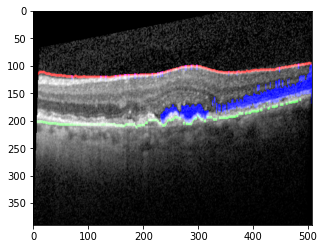

Length is  498 cropped_PL008.bmp
RPE VALS  [195, 194, 195, 196, 194, 195, 196, 194, 195, 197, 196, 197, 196, 197, 198, 197, 198, 199, 197, 198, 199, 200, 197, 198, 199, 200, 198, 199, 200, 201, 198, 199, 200, 201, 197, 198, 199, 200, 201, 197, 198, 199, 200, 201, 202, 139, 140, 141, 198, 199, 200, 201, 202, 134, 135, 139, 140, 141, 199, 200, 201, 202, 133, 134, 135, 140, 201, 134, 128, 128, 127, 128, 127, 128, 134, 135, 136, 202, 134, 135, 136, 137, 201, 202, 203, 135, 136, 137, 138, 201, 202, 203, 137, 138, 139, 140, 201, 202, 203, 138, 139, 140, 141, 201, 202, 203, 138, 139, 140, 141, 201, 202, 203, 138, 139, 140, 141, 201, 202, 203, 137, 138, 139, 140, 141, 201, 202, 203, 204, 139, 140, 202, 203, 204, 203, 203, 204, 203, 204, 205, 203, 204, 205, 203, 204, 205, 141, 204, 205, 130, 131, 132, 133, 140, 141, 142, 131, 132, 133, 140, 141, 142, 140, 141, 142, 141, 142, 205, 206, 140, 141, 142, 205, 206, 207, 139, 140, 141, 142, 143, 205, 206, 138, 139, 140, 141, 142, 143, 205, 206, 135, 1

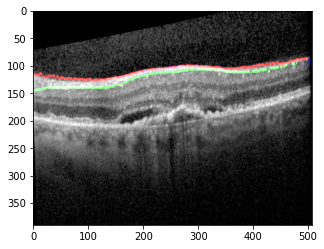

Length is  492 cropped_PL015.bmp
RPE VALS  [129, 130, 128, 129, 130, 129, 130, 194, 195, 194, 195, 196, 194, 195, 196, 195, 199, 200, 198, 199, 200, 201, 198, 199, 200, 201, 199, 200, 201, 134, 135, 200, 133, 134, 133, 134, 134, 130, 131, 129, 130, 129, 130, 129, 130, 130, 131, 130, 131, 131, 205, 129, 204, 205, 206, 203, 204, 205, 204, 130, 131, 205, 206, 131, 206, 206]
ILM MODE  120
RPE VALS  [194, 195, 194, 195, 196, 194, 195, 196, 195, 199, 200, 198, 199, 200, 201, 198, 199, 200, 201, 199, 200, 201, 200, 205, 204, 205, 206, 203, 204, 205, 204, 205, 206, 206, 206]
492
(390, 508)


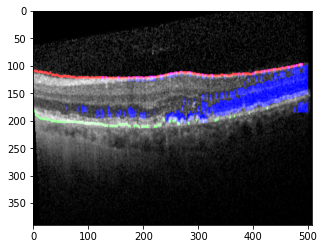

Length is  501 cropped_PL011.bmp
RPE VALS  [128, 134, 135, 136, 190, 191, 192, 193, 194, 195, 133, 134, 135, 136, 190, 191, 192, 193, 194, 195, 131, 132, 133, 134, 135, 136, 190, 191, 192, 193, 194, 195, 130, 131, 132, 133, 134, 135, 136, 190, 191, 192, 193, 194, 195, 196, 126, 127, 128, 131, 132, 133, 134, 135, 190, 191, 192, 193, 194, 195, 196, 126, 127, 128, 131, 132, 133, 134, 191, 192, 193, 194, 195, 196, 127, 131, 132, 133, 191, 192, 193, 194, 195, 196, 131, 132, 133, 192, 193, 194, 195, 196, 131, 132, 133, 134, 193, 194, 195, 196, 130, 131, 132, 133, 134, 193, 194, 195, 196, 130, 131, 132, 133, 134, 193, 194, 195, 196, 130, 131, 132, 133, 134, 194, 195, 196, 130, 131, 132, 133, 134, 194, 195, 196, 197, 130, 131, 132, 133, 134, 135, 194, 195, 196, 197, 130, 131, 132, 133, 134, 135, 194, 195, 196, 197, 198, 127, 128, 129, 130, 131, 132, 133, 134, 135, 194, 195, 196, 197, 198, 127, 128, 129, 130, 131, 132, 133, 134, 135, 194, 195, 196, 197, 198, 128, 129, 130, 131, 132, 133, 134, 1

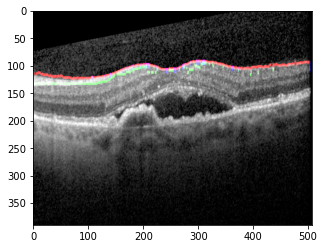

Length is  497 cropped_PL013.bmp
RPE VALS  [128, 128, 192, 193, 194, 191, 192, 193, 194, 191, 192, 193, 194, 191, 192, 193, 194, 191, 192, 193, 194, 130, 131, 132, 191, 192, 193, 194, 130, 131, 132, 191, 192, 193, 194, 191, 192, 193, 194, 191, 192, 193, 194, 192, 193, 194, 192, 193, 194, 195, 127, 192, 193, 194, 195, 126, 127, 128, 192, 193, 194, 195, 126, 127, 128, 129, 192, 193, 194, 195, 196, 127, 193, 194, 195, 196, 193, 194, 195, 196, 193, 194, 195, 196, 193, 194, 195, 196, 129, 130, 193, 194, 195, 196, 129, 130, 194, 195, 196, 128, 129, 130, 131, 195, 196, 127, 128, 129, 130, 131, 132, 126, 127, 128, 129, 130, 131, 132, 126, 127, 128, 129, 130, 131, 132, 195, 196, 126, 127, 128, 129, 130, 131, 194, 195, 196, 197, 126, 127, 128, 129, 130, 131, 195, 196, 197, 127, 128, 129, 130, 131, 132, 196, 129, 130, 131, 132, 133, 130, 131, 132, 133, 130, 131, 132, 133, 131, 132, 133, 134, 132, 133, 134, 197, 198, 197, 198, 199, 198, 199, 198, 199, 200, 129, 130, 131, 132, 198, 199, 128, 129, 1

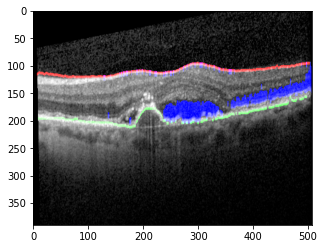

Length is  497 cropped_PL010.bmp
RPE VALS  [195, 195, 196, 196, 196, 196, 195, 196, 197, 195, 196, 197, 196, 197, 197, 133, 133, 203, 202, 203, 202, 203, 202, 203, 135, 136, 137, 134, 135, 136, 137, 133, 134, 135, 136, 132, 133, 134, 135, 132, 133, 134, 135, 132, 133, 134, 135, 136, 132, 133, 134, 135, 136, 137, 132, 133, 134, 135, 136, 137, 133, 134, 135, 136, 133, 134, 135, 132, 132, 201, 202, 203, 136, 137, 201, 202, 203, 204, 135, 136, 137, 138, 201, 202, 203, 204, 135, 136, 137, 138, 203, 135, 136, 137, 128, 129, 207, 208, 127, 128, 129, 127, 128, 129, 127, 128, 129, 127, 128, 129, 207, 127, 128, 129, 206, 207, 208, 127, 128, 207, 208, 128, 133, 134, 207, 208, 132, 133, 134, 207, 208, 132, 133, 134, 206, 207, 208, 132, 133, 134, 206, 207, 208, 133, 134, 206, 207, 206, 207, 206, 207, 208, 206, 207, 208, 206, 207, 208, 131, 205, 206, 207, 208, 130, 131, 132, 133, 134, 135, 205, 206, 207, 208, 130, 131, 132, 133, 134, 135, 206, 207, 130, 131, 132, 130, 131, 129, 130, 131, 129, 130, 1

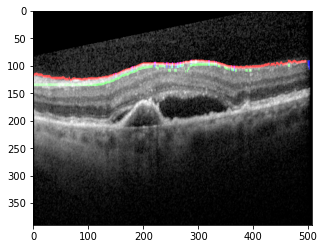

Length is  500 cropped_PL009.bmp
RPE VALS  [198, 198, 197, 138, 137, 138, 139, 138, 204, 205, 203, 204, 205, 203, 204, 205, 204, 135, 135, 130, 131, 130, 131, 135, 136, 137, 138, 139, 134, 135, 136, 137, 138, 139, 140, 134, 135, 136, 137, 138, 139, 134, 135, 136, 137, 138, 139, 134, 135, 136, 137, 138, 139, 135, 136, 137, 138, 139, 135, 136, 137, 138, 139, 134, 135, 136, 137, 138, 139, 206, 207, 133, 134, 135, 136, 137, 138, 139, 132, 133, 134, 135, 136, 137, 138, 139, 132, 133, 134, 135, 136, 137, 138, 132, 133, 134, 135, 136, 137, 134, 135, 136, 135, 206, 207, 207, 137, 138, 139, 136, 137, 138, 139, 135, 136, 137, 138, 139, 134, 135, 136, 133, 134, 135, 133, 134, 135, 133, 134, 131, 132, 133, 130, 131, 132, 133, 129, 130, 131, 128, 129, 130, 128, 129, 130, 131, 130, 131, 132, 133, 131, 132, 133, 131, 132, 133, 131, 132, 131, 130, 131, 132, 131, 126, 127, 128, 129, 130, 124, 125, 126, 127, 128, 129, 130, 123, 124, 125, 126, 123, 124, 125, 126, 124, 125, 126, 126, 126, 199, 200, 199, 2

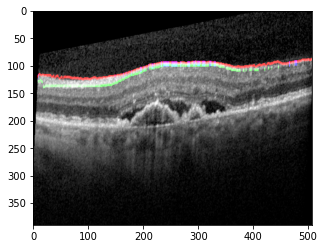

Length is  497 cropped_PL012.bmp
RPE VALS  [129, 130, 129, 130, 131, 129, 130, 131, 201, 202, 203, 204, 205, 202, 203, 204, 205, 202, 203, 204, 205, 203, 204, 205, 206, 203, 204, 205, 204, 205, 132, 133, 131, 132, 133, 134, 132, 133, 134, 131, 132, 133, 134, 131, 132, 133, 130, 131, 132, 130, 131, 132, 130, 131, 132, 133, 129, 130, 131, 132, 130, 130, 129, 130, 131, 130, 181, 182, 181, 187, 187]
ILM MODE  121
RPE VALS  [201, 202, 203, 204, 205, 202, 203, 204, 205, 202, 203, 204, 205, 203, 204, 205, 206, 203, 204, 205, 204, 205, 181, 182, 181, 187, 187]
497
(390, 508)


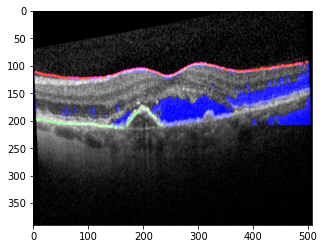

Length is  501 cropped_PL017.bmp
RPE VALS  [115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 184, 185, 186, 187, 188, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 184, 185, 186, 187, 188, 118, 119, 120, 121, 122, 123, 124, 125, 126, 184, 185, 186, 187, 188, 118, 119, 120, 121, 122, 123, 124, 125, 126, 184, 185, 186, 187, 188, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 184, 185, 186, 187, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 184, 185, 186, 187, 118, 119, 120, 121, 122, 123, 124, 125, 126, 184, 185, 186, 187, 188, 119, 120, 121, 122, 123, 124, 125, 126, 184, 185, 186, 187, 188, 115, 119, 120, 121, 122, 123, 124, 125, 126, 184, 185, 186, 187, 188, 115, 119, 120, 121, 122, 123, 124, 125, 126, 184, 185, 186, 187, 119, 120, 121, 122, 123, 184, 185, 186, 187, 188, 120, 185, 186, 187, 186, 187, 188, 189, 123, 187, 188, 189, 122, 123, 124, 186, 187, 188, 189, 190, 120, 121, 122, 123, 124, 125, 186, 187, 188, 189, 190, 120, 121, 122, 123, 124, 125, 1

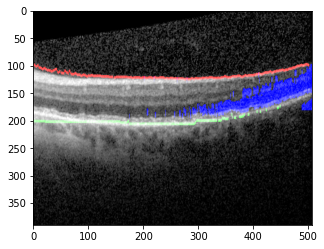

Length is  485 cropped_PL018.bmp
RPE VALS  [118, 119, 120, 121, 122, 183, 184, 185, 186, 187, 119, 120, 121, 183, 184, 185, 186, 187, 184, 185, 186, 187, 184, 185, 186, 187, 185, 186, 187, 184, 185, 186, 184, 185, 186, 184, 185, 186, 187, 188, 184, 185, 186, 187, 188, 189, 185, 186, 187, 188, 189, 119, 185, 186, 187, 188, 189, 119, 185, 186, 187, 188, 186, 187, 188, 186, 187, 188, 186, 187, 188, 189, 186, 187, 188, 189, 190, 186, 187, 188, 189, 190, 187, 188, 189, 190, 187, 188, 189, 190, 187, 188, 189, 187, 188, 189, 190, 187, 188, 189, 190, 188, 189, 190, 191, 128, 189, 190, 191, 127, 128, 129, 189, 190, 191, 128, 188, 189, 190, 191, 188, 189, 190, 188, 189, 190, 191, 188, 189, 190, 191, 188, 189, 190, 191, 188, 189, 190, 191, 192, 189, 190, 191, 192, 193, 189, 190, 191, 192, 193, 189, 190, 191, 192, 193, 190, 191, 192, 193, 190, 191, 192, 193, 194, 130, 189, 190, 191, 192, 193, 194, 129, 130, 131, 189, 190, 191, 192, 193, 194, 128, 129, 130, 189, 190, 191, 192, 193, 194, 190, 191, 1

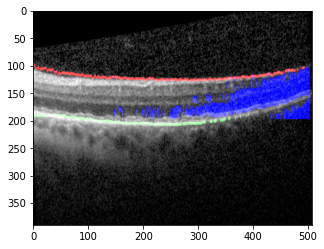

Length is  482 cropped_PL016.bmp
RPE VALS  [187, 186, 187, 188, 186, 187, 187, 188, 187, 188, 189, 188, 189, 189, 188, 189, 190, 191, 188, 189, 190, 191, 188, 189, 190, 191, 192, 189, 190, 191, 192, 189, 190, 191, 192, 190, 191, 128, 128, 127, 128, 126, 127, 128, 120, 121, 126, 127, 128, 120, 121, 126, 127, 128, 129, 190, 191, 192, 193, 194, 195, 126, 127, 128, 129, 130, 190, 191, 192, 193, 194, 195, 127, 128, 129, 130, 191, 192, 193, 194, 195, 128, 129, 192, 193, 194, 195, 192, 193, 194, 195, 192, 193, 194, 195, 125, 126, 127, 191, 192, 193, 194, 195, 125, 126, 127, 128, 191, 192, 193, 194, 195, 124, 125, 126, 127, 128, 191, 192, 193, 194, 127, 192, 193, 194, 192, 193, 194, 132, 192, 193, 194, 195, 192, 193, 194, 195, 196, 193, 194, 195, 196, 194, 195, 196, 126, 125, 126, 133, 133, 134, 196, 197, 198, 133, 195, 196, 197, 198, 199, 195, 196, 197, 198, 199, 195, 196, 197, 198, 199, 196, 197, 198, 197, 198, 198, 199, 200, 197, 198, 199, 200, 201, 197, 198, 199, 200, 197, 198, 199, 200, 1

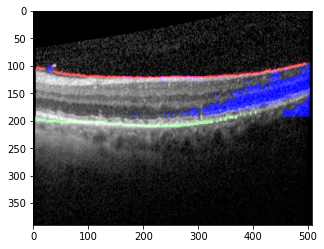

Length is  470 cropped_PL020.bmp
RPE VALS  [180, 181, 122, 123, 179, 180, 181, 182, 115, 116, 117, 118, 121, 122, 123, 179, 180, 181, 182, 115, 116, 117, 118, 122, 123, 179, 180, 181, 182, 183, 178, 179, 180, 181, 182, 183, 184, 178, 179, 180, 181, 182, 183, 111, 112, 113, 114, 115, 116, 117, 120, 121, 179, 180, 181, 182, 183, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 180, 181, 182, 113, 114, 115, 116, 117, 118, 119, 120, 121, 181, 117, 118, 119, 120, 119, 120, 121, 182, 183, 119, 120, 121, 181, 182, 183, 184, 111, 112, 181, 182, 183, 184, 185, 111, 112, 113, 182, 183, 184, 185, 111, 112, 113, 182, 183, 184, 185, 186, 111, 112, 117, 118, 182, 183, 184, 185, 186, 111, 112, 117, 118, 127, 183, 184, 185, 110, 111, 112, 126, 127, 128, 129, 183, 184, 185, 110, 111, 112, 126, 127, 128, 129, 184, 110, 111, 128, 129, 184, 185, 110, 111, 184, 185, 109, 110, 111, 183, 184, 185, 109, 110, 111, 183, 184, 109, 110, 111, 183, 184, 110, 111, 118, 184, 185, 186, 187, 118, 119, 184, 1

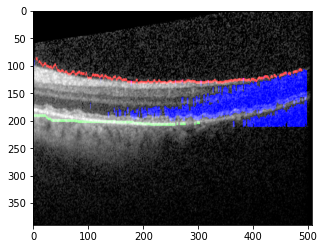

Length is  480 cropped_PL022.bmp
RPE VALS  [115, 116, 117, 118, 175, 176, 177, 115, 116, 117, 175, 176, 177, 176, 109, 110, 111, 175, 176, 177, 107, 108, 109, 110, 118, 175, 176, 177, 101, 102, 103, 107, 108, 117, 118, 176, 177, 101, 102, 101, 102, 179, 180, 179, 180, 179, 180, 179, 109, 110, 116, 117, 115, 116, 117, 118, 115, 116, 117, 118, 117, 184, 183, 184, 185, 111, 112, 183, 184, 185, 111, 184, 185, 184, 185, 186, 184, 185, 186, 183, 184, 185, 114, 184, 113, 114, 115, 112, 113, 114, 115, 116, 185, 112, 113, 114, 115, 116, 184, 185, 186, 112, 113, 114, 115, 116, 124, 125, 184, 185, 186, 113, 114, 115, 116, 117, 118, 123, 124, 125, 184, 185, 186, 114, 115, 116, 117, 118, 122, 123, 124, 184, 185, 186, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 184, 185, 186, 187, 117, 118, 119, 121, 122, 123, 124, 126, 127, 128, 129, 185, 186, 116, 122, 123, 124, 125, 126, 127, 128, 129, 131, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 122, 123, 124, 125, 126, 127, 128, 129, 130, 1

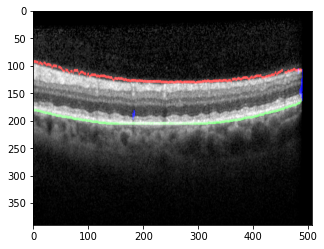

Length is  493 cropped_PL021.bmp
RPE VALS  [115, 116, 115, 116, 117, 116, 105, 106, 107, 124, 104, 105, 106, 107, 108, 124, 105, 106, 107, 108, 109, 107, 108, 180, 181, 182, 181, 182, 108, 109, 111, 112, 113, 114, 115, 182, 111, 112, 113, 114, 115, 116, 182, 112, 113, 114, 115, 116, 117, 118, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 114, 115, 116, 117, 118, 119, 120, 121, 122, 117, 118, 119, 120, 121, 122, 119, 120, 114, 115, 113, 114, 115, 116, 113, 114, 115, 116, 117, 113, 114, 115, 116, 117, 121, 122, 113, 114, 115, 116, 117, 121, 122, 123, 114, 115, 116, 121, 122, 123, 121, 122, 186, 187, 185, 186, 187, 188, 185, 186, 187, 188, 186, 187, 188, 187, 187, 188, 125, 126, 127, 128, 187, 188, 125, 126, 127, 128, 129, 125, 126, 127, 128, 125, 126, 127, 128, 125, 126, 127, 128, 126, 127, 128, 129, 127, 128, 129, 130, 189, 119, 128, 129, 188, 189, 190, 118, 119, 120, 189, 119, 126, 127, 128, 129, 130, 126, 127, 128, 129, 130, 126, 127, 128, 129, 125, 126, 127, 128, 124, 125, 126, 1

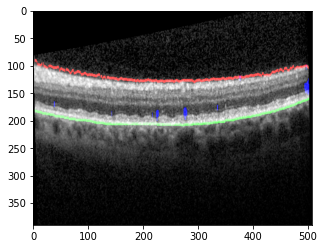

Length is  449 cropped_PL019.bmp
RPE VALS  [182, 117, 118, 182, 113, 114, 115, 116, 117, 118, 119, 182, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 182, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 180, 181, 182, 183, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 179, 180, 181, 110, 111, 112, 113, 114, 115, 116, 117, 118, 180, 112, 113, 114, 115, 116, 113, 114, 115, 183, 184, 185, 182, 183, 184, 185, 186, 181, 182, 183, 184, 185, 186, 182, 183, 184, 185, 182, 183, 184, 185, 181, 182, 183, 184, 185, 181, 182, 183, 184, 185, 186, 182, 183, 184, 185, 186, 187, 115, 116, 183, 184, 185, 186, 187, 115, 116, 183, 184, 185, 186, 187, 188, 183, 184, 185, 186, 187, 188, 183, 184, 185, 186, 187, 184, 185, 186, 187, 188, 184, 185, 186, 187, 188, 121, 122, 184, 185, 186, 187, 188, 189, 121, 122, 123, 184, 185, 186, 187, 188, 116, 117, 121, 122, 123, 124, 183, 184, 185, 186, 187, 188, 189, 115, 116, 117, 118, 121, 122, 123, 124, 182, 183, 184, 185, 186, 187, 188, 1

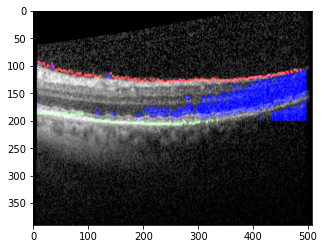

Length is  490 cropped_PL024.bmp
RPE VALS  [174, 173, 174, 175, 174, 175, 174, 175, 175, 176, 175, 175, 175, 176, 176, 177, 176, 177, 178, 177, 178, 185, 184, 185, 186, 185, 181, 185, 181, 185, 184, 185, 186, 184, 185, 186, 185, 187, 188, 187, 188, 188, 193, 192, 193, 194, 192, 193, 190, 191, 190, 190, 191, 192, 193, 194, 190, 191, 192, 193, 194, 190, 191, 192, 190, 191, 194, 195, 129, 130, 131, 126, 127, 128, 129, 130, 131, 125, 126, 127, 128, 129, 130, 126, 127, 196, 195, 196, 195, 196, 192, 192, 129, 130, 197, 128, 129, 130, 196, 197, 198, 128, 129, 130, 197, 129, 139, 140, 139, 140, 196, 197, 196, 199, 200, 198, 199, 200, 201, 129, 198, 199, 200, 201, 128, 129, 130, 199, 200, 128, 129, 140, 140, 141, 135, 141, 142, 203, 134, 135, 136, 202, 203, 204, 134, 135, 136, 202, 203, 204, 134, 135, 203, 204, 137, 138, 136, 137, 138, 139, 203, 204, 136, 137, 138, 139, 203, 204, 136, 137, 138, 139, 203, 204, 136, 137, 138, 139, 203, 204, 205, 136, 137, 138, 204, 205, 203, 204, 205, 202, 203, 2

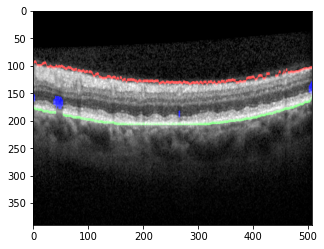

Length is  481 cropped_PL023.bmp
RPE VALS  [123, 124, 182, 183, 111, 112, 181, 182, 183, 184, 111, 112, 181, 182, 183, 112, 113, 181, 182, 183, 182, 183, 184, 114, 182, 183, 184, 185, 182, 183, 184, 114, 115, 116, 184, 112, 113, 185, 186, 112, 113, 184, 185, 184, 185, 184, 185, 185, 186, 185, 186, 116, 117, 186, 116, 117, 187, 186, 187, 187, 114, 115, 125, 126, 114, 115, 116, 117, 126, 115, 116, 117, 118, 126, 127, 188, 116, 117, 118, 126, 127, 128, 187, 188, 117, 126, 127, 127, 188, 189, 117, 118, 187, 188, 189, 190, 116, 117, 118, 187, 188, 189, 117, 118, 188, 189, 188, 189, 188, 189, 188, 189, 188, 189, 188, 189, 188, 189, 190, 189, 190, 189, 190, 191, 189, 190, 191, 192, 189, 190, 191, 192, 189, 190, 191, 190, 191, 190, 191, 191, 192, 191, 192, 192, 193, 194, 121, 122, 123, 124, 193, 194, 195, 122, 123, 124, 125, 194, 195, 127, 195, 127, 128, 194, 195, 195, 195, 196, 195, 196, 196, 197, 196, 127, 128, 129, 197, 198, 127, 128, 129, 130, 197, 198, 128, 129, 197, 198, 135, 136, 137, 1

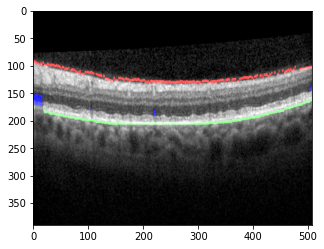

Length is  508 cropped_DH000.tif
RPE VALS  [285, 285, 286, 287, 289, 290, 289, 290, 289, 290, 289, 290, 289, 290, 294, 295, 294, 295, 296, 295, 242, 243, 242, 296, 295, 296, 297, 295, 296, 297, 298, 296, 297, 298, 298, 298, 299, 300, 301, 300, 301, 302, 300, 301, 302, 300, 301, 302, 300, 301, 302, 301, 302, 303, 301, 302, 303, 301, 302, 303, 304, 302, 303, 303, 303, 302, 303, 304, 302, 303, 304, 302, 303, 304, 303, 304, 304, 304, 305, 306, 306, 307, 307, 310, 311, 312, 310, 311, 312, 311, 312, 313, 314, 311, 312, 313, 314, 311, 312, 313, 310, 311, 312, 313, 311, 312, 313, 311, 312, 313, 314, 312, 313, 314, 312, 313, 314, 313, 314, 314, 315, 315, 315, 315, 315, 316, 315, 316, 317, 316, 316, 317, 317, 318, 318, 319, 317, 318, 319, 320, 317, 318, 319, 318, 319, 319, 320, 319, 320, 321, 319, 320, 321, 319, 320, 321, 320, 321, 322, 321, 320, 321, 320, 321, 322, 320, 321, 322, 320, 321, 322, 321, 321, 323, 323, 323, 324, 322, 323, 324, 262, 263, 262, 323, 322, 323, 324, 323, 326, 327, 326, 3

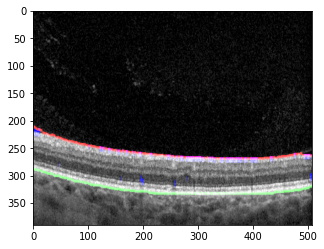

Length is  508 cropped_DH003.tif
RPE VALS  [283, 284, 285, 283, 284, 285, 284, 285, 286, 284, 285, 286, 284, 285, 286, 284, 285, 286, 220, 221, 286, 220, 221, 285, 286, 287, 286, 290, 291, 289, 290, 291, 290, 291, 226, 227, 228, 229, 223, 224, 225, 226, 227, 228, 229, 223, 224, 225, 226, 292, 224, 225, 291, 292, 293, 292, 293, 294, 292, 293, 294, 295, 293, 294, 295, 294, 295, 294, 295, 296, 228, 295, 296, 227, 228, 295, 296, 227, 228, 231, 232, 233, 231, 232, 233, 231, 232, 233, 231, 232, 233, 231, 232, 233, 231, 232, 233, 230, 231, 232, 233, 229, 230, 231, 232, 233, 297, 298, 299, 228, 229, 230, 231, 232, 297, 298, 299, 228, 229, 298, 299, 299, 233, 234, 235, 232, 233, 234, 235, 232, 233, 234, 235, 301, 302, 231, 232, 233, 234, 235, 232, 233, 234, 235, 235, 236, 237, 234, 235, 236, 237, 238, 235, 236, 237, 238, 236, 237, 238, 234, 235, 236, 237, 238, 239, 234, 235, 236, 237, 238, 239, 239, 238, 239, 238, 239, 310, 311, 244, 244, 245, 244, 245, 312, 311, 312, 313, 312, 246, 246, 246, 3

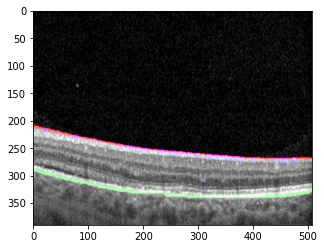

Length is  506 cropped_DH001.tif
RPE VALS  [283, 284, 285, 286, 286, 287, 286, 287, 288, 287, 288, 287, 288, 287, 288, 287, 288, 287, 288, 289, 288, 289, 289, 290, 289, 290, 289, 290, 289, 290, 291, 290, 291, 290, 291, 290, 291, 290, 291, 292, 290, 291, 292, 291, 292, 293, 291, 292, 293, 292, 293, 292, 293, 292, 293, 294, 292, 293, 294, 293, 295, 296, 295, 296, 297, 295, 296, 297, 296, 297, 296, 297, 296, 297, 296, 297, 298, 297, 298, 297, 298, 299, 297, 298, 299, 300, 301, 300, 301, 300, 301, 302, 300, 301, 302, 300, 301, 302, 300, 301, 302, 301, 302, 302, 301, 302, 302, 303, 303, 304, 303, 304, 305, 303, 304, 305, 304, 305, 304, 305, 306, 304, 305, 306, 304, 305, 306, 305, 306, 307, 305, 306, 307, 306, 307, 306, 307, 307, 307, 306, 307, 308, 306, 307, 308, 307, 308, 307, 308, 307, 308, 309, 308, 309, 308, 309, 310, 310, 311, 310, 311, 310, 311, 311, 312, 311, 312, 313, 311, 312, 313, 311, 312, 313, 311, 312, 313, 311, 312, 313, 311, 312, 313, 314, 312, 313, 314, 315, 312, 313, 314, 3

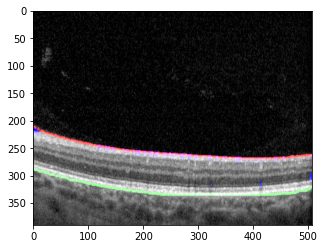

Length is  508 cropped_DH002.tif
RPE VALS  [224, 225, 226, 285, 284, 285, 286, 285, 286, 230, 223, 224, 225, 230, 222, 223, 224, 225, 226, 286, 287, 222, 223, 224, 225, 286, 287, 288, 223, 224, 286, 287, 288, 287, 288, 287, 288, 289, 288, 230, 230, 230, 292, 292, 234, 233, 234, 235, 233, 234, 233, 293, 294, 293, 294, 295, 293, 294, 295, 294, 295, 296, 294, 295, 296, 294, 295, 296, 295, 296, 297, 296, 297, 298, 296, 297, 298, 296, 297, 298, 297, 298, 300, 301, 300, 301, 302, 300, 301, 302, 300, 301, 302, 301, 302, 301, 302, 303, 301, 302, 303, 302, 303, 304, 303, 304, 304, 304, 304, 305, 304, 305, 306, 240, 241, 305, 306, 240, 241, 241, 307, 308, 308, 309, 309, 310, 311, 310, 311, 309, 310, 311, 310, 312, 312, 313, 313, 313, 313, 313, 314, 315, 313, 314, 315, 313, 314, 315, 316, 313, 314, 315, 316, 314, 315, 316, 315, 316, 315, 316, 317, 316, 317, 317, 318, 318, 318, 318, 319, 324, 325, 324, 325, 326, 327, 326, 327, 328, 326, 327, 326, 327, 328, 327, 261, 328, 328, 328, 328, 330, 329, 3

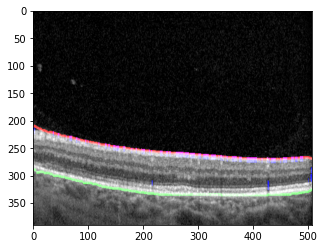

Length is  508 cropped_DH006.tif
RPE VALS  [209, 210, 211, 210, 290, 291, 290, 291, 214, 215, 216, 217, 213, 214, 215, 216, 217, 218, 219, 213, 214, 215, 216, 217, 218, 219, 212, 213, 214, 215, 216, 217, 218, 212, 213, 214, 215, 213, 214, 290, 214, 215, 216, 217, 213, 214, 215, 216, 217, 218, 214, 215, 216, 217, 218, 215, 216, 217, 218, 218, 219, 216, 217, 218, 215, 216, 217, 218, 219, 216, 217, 267, 268, 266, 267, 268, 269, 270, 271, 272, 267, 268, 269, 270, 271, 272, 273, 274, 275, 272, 273, 274, 275, 293, 294, 295, 292, 293, 294, 295, 296, 293, 294, 295, 301, 300, 301, 302, 220, 301, 219, 220, 221, 219, 220, 221, 222, 220, 221, 222, 305, 306, 307, 308, 304, 305, 306, 307, 308, 309, 305, 306, 307, 308, 306, 307, 223, 224, 225, 225, 226, 225, 226, 283, 283, 312, 313, 312, 313, 314, 313, 314, 315, 316, 315, 316, 227, 228, 226, 227, 228, 227, 229, 229, 229, 230, 231, 232, 230, 231, 232, 233, 231, 232, 233, 232, 232, 232, 320, 321, 232, 320, 321, 231, 232, 233, 231, 232, 233, 234, 234, 3

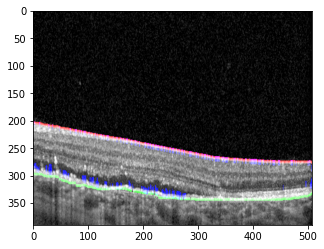

Length is  508 cropped_DH007.tif
RPE VALS  [205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 205, 206, 207, 208, 209, 210, 211, 212, 213, 293, 294, 206, 207, 208, 209, 210, 211, 212, 293, 294, 206, 207, 208, 209, 210, 211, 212, 206, 207, 208, 209, 210, 211, 212, 207, 208, 209, 210, 211, 212, 213, 207, 208, 209, 210, 211, 212, 213, 214, 210, 211, 212, 213, 214, 215, 210, 211, 212, 213, 214, 215, 211, 212, 213, 214, 212, 213, 208, 209, 210, 211, 212, 213, 208, 209, 210, 211, 212, 213, 214, 207, 208, 209, 210, 211, 212, 213, 214, 208, 209, 210, 211, 212, 213, 214, 209, 210, 211, 212, 213, 214, 210, 211, 212, 213, 298, 299, 298, 299, 298, 299, 298, 299, 298, 299, 300, 299, 217, 217, 213, 214, 213, 214, 303, 303, 303, 304, 303, 304, 305, 304, 305, 304, 305, 216, 303, 304, 305, 216, 217, 218, 303, 304, 216, 217, 218, 219, 217, 218, 219, 217, 218, 219, 306, 307, 217, 218, 219, 306, 307, 217, 218, 216, 217, 218, 216, 217, 303, 308, 303, 308, 2

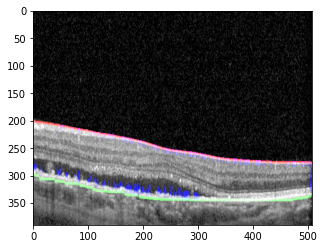

Length is  508 cropped_DH004.tif
RPE VALS  [285, 286, 287, 286, 287, 219, 220, 221, 287, 220, 218, 221, 222, 221, 222, 295, 296, 294, 295, 296, 294, 295, 229, 228, 229, 230, 228, 229, 230, 228, 229, 230, 228, 229, 230, 229, 224, 225, 226, 227, 224, 225, 226, 227, 230, 231, 229, 230, 231, 228, 229, 230, 231, 227, 228, 229, 230, 227, 228, 229, 231, 231, 232, 231, 232, 233, 230, 231, 232, 233, 229, 230, 231, 232, 230, 231, 232, 230, 231, 306, 234, 235, 234, 235, 236, 234, 235, 310, 310, 237, 238, 237, 238, 239, 237, 238, 239, 240, 241, 240, 241, 242, 243, 241, 242, 243, 316, 317, 316, 317, 318, 317, 298, 243, 244, 298, 242, 243, 244, 241, 242, 243, 240, 241, 242, 243, 240, 241, 242, 243, 241, 242, 243, 242, 242, 321, 322, 321, 322, 249, 250, 248, 249, 250, 249, 250, 248, 249, 250, 248, 249, 250, 251, 248, 249, 250, 251, 248, 249, 250, 249, 250, 249, 327, 328, 310, 310, 254, 253, 254, 255, 328, 329, 254, 328, 329, 329, 329, 328, 329, 330, 328, 329, 330, 329, 257, 258, 329, 330, 257, 258, 2

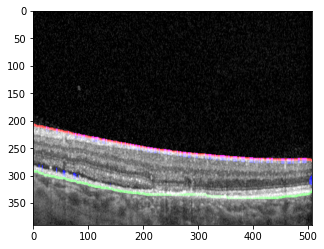

Length is  508 cropped_DH005.tif
RPE VALS  [222, 223, 222, 223, 217, 218, 218, 219, 218, 219, 291, 292, 293, 223, 293, 294, 222, 223, 224, 223, 216, 295, 296, 216, 294, 295, 296, 294, 295, 296, 295, 296, 297, 298, 296, 297, 298, 297, 297, 298, 220, 221, 222, 297, 298, 299, 220, 221, 222, 298, 299, 219, 220, 221, 299, 219, 220, 221, 223, 221, 222, 223, 224, 225, 226, 220, 221, 222, 223, 224, 225, 226, 220, 221, 222, 223, 224, 225, 226, 220, 221, 222, 223, 224, 225, 220, 221, 222, 223, 297, 298, 299, 300, 301, 302, 297, 298, 299, 300, 301, 299, 300, 226, 225, 226, 227, 223, 224, 225, 226, 227, 228, 301, 302, 303, 225, 226, 227, 228, 302, 303, 227, 228, 226, 227, 292, 293, 292, 293, 229, 230, 228, 229, 230, 230, 232, 233, 232, 232, 232, 231, 232, 233, 231, 232, 233, 232, 290, 291, 289, 290, 291, 292, 279, 280, 281, 290, 291, 278, 279, 280, 281, 279, 280, 281, 312, 313, 314, 312, 313, 314, 312, 313, 314, 318, 319, 318, 319, 238, 238, 239, 239, 240, 238, 239, 240, 238, 239, 238, 239, 238, 2

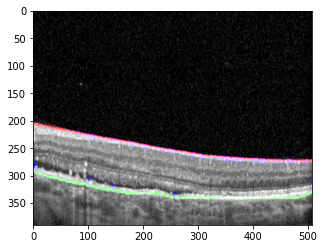

Length is  508 cropped_DH010.tif
RPE VALS  [196, 197, 198, 199, 195, 196, 197, 198, 199, 195, 196, 197, 198, 199, 200, 201, 195, 196, 197, 198, 199, 200, 201, 308, 195, 196, 197, 198, 199, 200, 201, 308, 195, 196, 200, 247, 248, 247, 235, 236, 237, 238, 239, 234, 235, 236, 237, 238, 239, 240, 234, 235, 236, 237, 238, 239, 240, 234, 235, 236, 237, 238, 239, 240, 235, 236, 237, 238, 239, 197, 198, 199, 200, 201, 202, 235, 236, 237, 238, 196, 197, 198, 199, 200, 201, 202, 203, 196, 197, 198, 199, 200, 201, 202, 203, 197, 198, 199, 200, 201, 202, 198, 199, 200, 201, 202, 234, 198, 199, 200, 201, 202, 203, 199, 200, 201, 202, 203, 199, 200, 201, 202, 203, 200, 201, 231, 229, 230, 231, 232, 229, 230, 231, 238, 239, 240, 241, 237, 238, 239, 240, 241, 236, 237, 238, 239, 240, 241, 233, 234, 235, 236, 237, 238, 239, 240, 233, 234, 235, 236, 237, 238, 239, 240, 241, 238, 239, 240, 241, 239, 240, 241, 239, 240, 241, 239, 240, 241, 239, 240, 241, 316, 315, 316, 315, 316, 317, 315, 316, 317, 315, 3

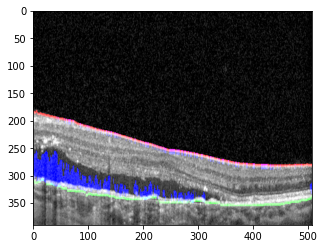

Length is  508 cropped_DH008.tif
RPE VALS  [203, 203, 208, 208, 205, 206, 207, 208, 204, 205, 206, 207, 208, 205, 206, 207, 208, 209, 206, 207, 208, 208, 209, 210, 208, 209, 210, 211, 209, 210, 211, 209, 210, 211, 301, 302, 209, 210, 211, 300, 301, 302, 208, 209, 210, 211, 301, 302, 303, 208, 209, 210, 211, 302, 209, 210, 211, 209, 210, 211, 209, 210, 211, 303, 304, 210, 211, 212, 302, 303, 304, 210, 211, 212, 213, 302, 303, 212, 213, 265, 266, 267, 264, 265, 266, 267, 268, 265, 266, 267, 268, 211, 212, 210, 211, 212, 213, 211, 212, 213, 214, 211, 212, 213, 214, 212, 213, 214, 212, 213, 214, 212, 213, 214, 215, 213, 214, 215, 216, 213, 214, 215, 214, 215, 213, 214, 215, 216, 321, 322, 214, 215, 216, 215, 216, 215, 216, 217, 216, 217, 216, 217, 216, 216, 217, 218, 216, 217, 218, 216, 217, 218, 215, 216, 217, 216, 314, 315, 316, 314, 315, 316, 218, 219, 218, 219, 220, 218, 219, 220, 221, 218, 219, 220, 218, 219, 318, 223, 222, 223, 318, 319, 221, 222, 223, 224, 319, 221, 222, 223, 320, 2

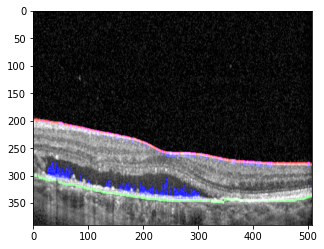

Length is  508 cropped_DH009.tif
RPE VALS  [202, 203, 204, 205, 201, 202, 203, 204, 205, 206, 207, 208, 201, 202, 203, 204, 205, 206, 207, 208, 209, 201, 202, 204, 205, 206, 207, 208, 217, 202, 205, 206, 207, 217, 201, 202, 206, 202, 209, 208, 209, 209, 212, 213, 211, 212, 213, 214, 211, 212, 213, 214, 211, 212, 213, 309, 310, 210, 211, 207, 206, 207, 208, 207, 211, 211, 212, 211, 212, 212, 211, 210, 211, 212, 210, 211, 212, 212, 213, 214, 211, 212, 213, 214, 212, 213, 214, 213, 247, 247, 216, 215, 216, 217, 216, 215, 216, 215, 216, 217, 216, 216, 321, 320, 321, 322, 323, 321, 322, 323, 322, 322, 321, 322, 320, 321, 322, 323, 321, 322, 323, 322, 323, 325, 326, 324, 325, 326, 326, 325, 326, 327, 324, 325, 326, 327, 328, 325, 326, 327, 326, 327, 326, 327, 328, 327, 227, 227, 228, 331, 332, 333, 331, 332, 333, 330, 331, 332, 333, 331, 332, 333, 332, 333, 332, 333, 334, 332, 333, 334, 335, 333, 334, 233, 232, 233, 234, 233, 337, 338, 339, 336, 337, 338, 339, 336, 337, 338, 339, 338, 339, 3

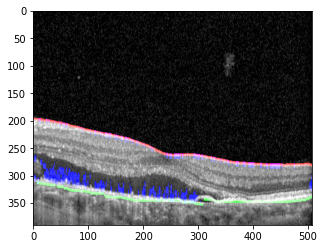

Length is  508 cropped_DH012.tif
RPE VALS  [179, 180, 179, 179, 183, 184, 182, 183, 184, 181, 182, 183, 184, 180, 181, 182, 183, 189, 189, 190, 189, 190, 191, 190, 191, 193, 328, 329, 240, 241, 242, 243, 239, 240, 241, 242, 243, 244, 240, 241, 242, 243, 244, 241, 242, 243, 242, 342, 342, 343, 342, 343, 345, 346, 345, 346, 345, 346, 345, 345, 346, 348, 349, 348, 349, 350, 348, 349, 350, 349, 350, 348, 349, 350, 348, 349, 350, 348, 349, 350, 348, 349, 350, 347, 348, 349, 346, 347, 348, 349, 346, 347, 348, 349, 347, 348, 349, 347, 348, 349, 347, 348, 349, 348, 349, 350, 350, 351, 350, 351, 351, 351, 351, 352, 351, 352, 351, 352, 351, 352, 352, 351, 352, 353, 351, 352, 353, 354, 355, 303, 352, 353, 354, 355, 303, 353, 354, 355, 356, 355, 354, 355, 356, 257, 258, 352, 353, 354, 355, 353, 354, 355, 351, 352, 353, 354, 355, 351, 352, 353, 354, 355, 350, 351, 352, 353, 354, 352, 353, 354, 329, 330, 329, 330, 331, 330, 331, 332, 333, 334, 330, 331, 332, 333, 334, 317, 317, 322, 323, 324, 322, 3

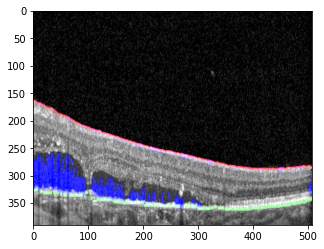

Length is  508 cropped_DH011.tif
RPE VALS  [193, 194, 236, 235, 236, 237, 236, 245, 246, 245, 246, 247, 245, 246, 247, 248, 247, 244, 245, 243, 244, 245, 246, 243, 244, 245, 246, 247, 244, 245, 246, 247, 248, 249, 247, 248, 324, 325, 326, 327, 323, 324, 325, 326, 327, 328, 324, 325, 326, 327, 325, 326, 327, 325, 326, 327, 326, 327, 326, 327, 326, 327, 327, 218, 217, 218, 219, 218, 331, 332, 331, 332, 333, 333, 339, 339, 340, 341, 340, 340, 339, 337, 338, 339, 337, 338, 339, 337, 338, 339, 337, 338, 339, 337, 338, 339, 337, 338, 336, 337, 335, 336, 337, 338, 336, 337, 336, 336, 336, 335, 336, 337, 338, 334, 335, 336, 337, 338, 339, 335, 336, 337, 338, 339, 336, 337, 338, 339, 337, 338, 339, 337, 338, 339, 340, 337, 338, 339, 340, 338, 339, 338, 339, 337, 338, 339, 337, 338, 339, 337, 338, 339, 338, 338, 336, 337, 336, 337, 338, 336, 337, 338, 336, 337, 338, 339, 336, 337, 338, 339, 337, 338, 338, 339, 340, 338, 339, 340, 338, 339, 340, 341, 339, 340, 341, 339, 340, 341, 342, 340, 341, 3

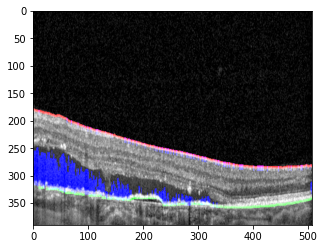

Length is  506 cropped_DH013.tif
RPE VALS  [170, 169, 170, 171, 172, 169, 170, 171, 174, 175, 176, 174, 175, 182, 183, 191, 192, 193, 193, 255, 255, 193, 193, 247, 247, 249, 250, 251, 249, 250, 251, 342, 343, 342, 343, 343, 344, 343, 344, 342, 343, 344, 342, 343, 343, 343, 217, 218, 219, 217, 218, 345, 346, 345, 346, 344, 345, 346, 343, 344, 345, 346, 344, 345, 346, 347, 345, 346, 347, 346, 349, 350, 349, 350, 351, 352, 353, 351, 352, 353, 354, 351, 352, 353, 352, 353, 351, 352, 351, 352, 353, 350, 351, 352, 349, 350, 351, 352, 350, 351, 352, 353, 351, 352, 351, 352, 352, 351, 352, 353, 333, 334, 335, 336, 337, 338, 339, 332, 333, 334, 335, 336, 337, 338, 339, 358, 359, 356, 357, 358, 355, 356, 357, 358, 356, 357, 358, 357, 267, 361, 362, 361, 362, 363, 361, 362, 363, 361, 362, 361, 362, 361, 359, 360, 358, 359, 360, 359, 360, 359, 360, 359, 360, 361, 359, 360, 361, 360, 356, 357, 355, 356, 357, 358, 355, 356, 357, 358, 356, 357, 358, 359, 357, 358, 359, 357, 358, 356, 357, 358, 359, 3

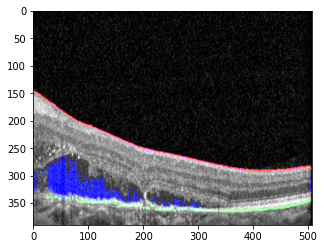

Length is  502 cropped_DH017.tif
RPE VALS  [125, 126, 127, 137, 137, 148, 148, 184, 183, 184, 201, 201, 224, 225, 224, 225, 221, 221, 343, 342, 343, 344, 343, 344, 242, 243, 242, 243, 234, 233, 234, 235, 234, 235, 235, 236, 345, 346, 240, 241, 242, 243, 244, 241, 242, 243, 244, 245, 246, 243, 244, 245, 246, 347, 348, 349, 347, 348, 349, 348, 349, 350, 350, 350, 351, 350, 351, 352, 350, 351, 352, 351, 352, 351, 352, 351, 352, 351, 351, 352, 353, 352, 353, 354, 352, 353, 354, 351, 352, 353, 351, 352, 353, 354, 355, 353, 354, 355, 356, 354, 355, 357, 358, 359, 360, 356, 357, 358, 359, 360, 357, 358, 318, 319, 318, 319, 364, 365, 366, 364, 365, 366, 365, 366, 365, 365, 345, 346, 344, 345, 346, 344, 345, 346, 345, 359, 360, 359, 302, 312, 302, 312, 358, 359, 360, 358, 359, 360, 361, 358, 359, 360, 361, 357, 358, 359, 360, 361, 362, 304, 357, 358, 359, 360, 361, 303, 304, 305, 358, 359, 360, 358, 359, 358, 359, 357, 358, 359, 360, 307, 356, 357, 358, 359, 360, 307, 356, 357, 358, 359, 360, 3

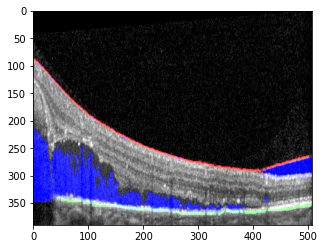

Length is  497 cropped_DH018.tif
RPE VALS  [162, 163, 162, 163, 164, 163, 164, 165, 166, 167, 164, 165, 166, 167, 164, 165, 166, 167, 168, 165, 166, 167, 168, 166, 167, 168, 169, 169, 170, 171, 170, 171, 172, 186, 187, 186, 187, 188, 189, 187, 188, 189, 188, 189, 190, 192, 193, 194, 192, 193, 194, 187, 187, 340, 339, 340, 341, 340, 341, 342, 341, 342, 343, 336, 337, 336, 337, 342, 342, 343, 341, 342, 343, 344, 342, 343, 344, 342, 343, 344, 345, 344, 345, 346, 343, 344, 345, 346, 343, 344, 345, 346, 343, 344, 345, 346, 344, 345, 346, 347, 344, 345, 346, 347, 348, 354, 355, 345, 346, 347, 348, 355, 346, 347, 348, 347, 347, 348, 347, 348, 347, 348, 346, 347, 346, 347, 348, 346, 347, 348, 349, 348, 349, 350, 348, 349, 350, 349, 350, 351, 269, 270, 271, 272, 350, 351, 269, 270, 271, 272, 351, 351, 351, 351, 350, 351, 352, 350, 351, 352, 353, 350, 351, 352, 353, 350, 351, 352, 351, 353, 354, 353, 354, 353, 354, 232, 235, 236, 231, 232, 233, 234, 235, 236, 232, 233, 234, 235, 236, 347, 355, 3

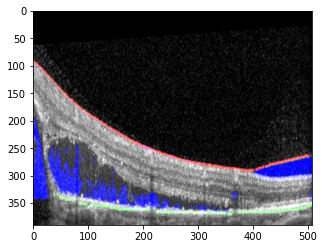

Length is  502 cropped_DH015.tif
RPE VALS  [117, 118, 119, 120, 121, 118, 119, 120, 125, 125, 126, 125, 126, 127, 117, 125, 126, 127, 128, 125, 126, 127, 131, 132, 133, 130, 131, 132, 133, 134, 131, 132, 133, 134, 132, 123, 124, 125, 130, 131, 132, 133, 134, 135, 136, 137, 124, 131, 132, 133, 134, 135, 136, 137, 138, 131, 132, 133, 135, 136, 137, 138, 139, 140, 136, 137, 138, 139, 140, 141, 136, 137, 138, 139, 140, 141, 134, 135, 136, 137, 138, 139, 134, 135, 136, 137, 146, 147, 194, 147, 194, 150, 151, 149, 150, 151, 152, 150, 151, 145, 146, 146, 149, 150, 151, 152, 153, 149, 150, 151, 152, 153, 346, 347, 346, 347, 346, 347, 270, 271, 270, 271, 349, 350, 348, 349, 350, 348, 349, 350, 350, 350, 352, 351, 352, 353, 351, 352, 353, 352, 353, 352, 353, 354, 353, 228, 229, 228, 229, 281, 282, 281, 282, 355, 356, 357, 355, 356, 357, 233, 234, 233, 234, 237, 238, 237, 238, 358, 359, 357, 358, 359, 357, 358, 359, 357, 358, 359, 358, 357, 358, 356, 357, 358, 359, 356, 357, 358, 359, 360, 356, 3

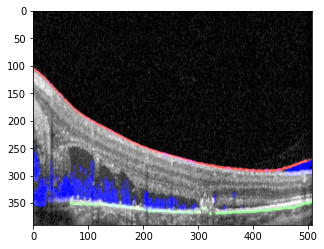

Length is  506 cropped_DH014.tif
RPE VALS  [139, 144, 144, 145, 145, 148, 149, 150, 147, 148, 149, 150, 147, 148, 149, 150, 147, 148, 153, 154, 146, 147, 148, 153, 154, 147, 147, 160, 161, 159, 160, 161, 162, 163, 159, 160, 161, 162, 163, 164, 162, 163, 164, 156, 156, 170, 171, 172, 171, 172, 179, 180, 171, 179, 180, 181, 179, 180, 174, 173, 174, 175, 168, 169, 170, 174, 175, 168, 169, 170, 169, 170, 180, 251, 252, 251, 252, 347, 348, 347, 348, 347, 348, 349, 347, 348, 349, 347, 348, 349, 209, 210, 209, 210, 211, 209, 210, 211, 212, 213, 214, 213, 214, 210, 211, 210, 211, 291, 292, 293, 290, 291, 292, 293, 294, 291, 292, 293, 221, 222, 358, 357, 358, 359, 358, 359, 358, 359, 358, 359, 357, 297, 298, 297, 298, 357, 358, 357, 358, 357, 358, 359, 357, 358, 359, 358, 359, 359, 360, 360, 361, 359, 360, 361, 360, 361, 362, 362, 362, 362, 264, 265, 264, 265, 362, 363, 361, 362, 363, 364, 362, 363, 364, 276, 275, 276, 275, 276, 363, 363, 364, 363, 364, 363, 363, 362, 363, 364, 362, 363, 364, 3

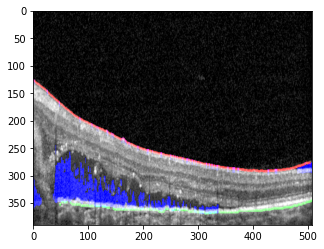

Length is  508 cropped_DH016.tif
RPE VALS  [108, 109, 110, 111, 112, 139, 140, 141, 142, 143, 144, 145, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 139, 140, 141, 142, 143, 144, 145, 146, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 139, 140, 141, 142, 143, 144, 145, 146, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 142, 143, 144, 145, 146, 104, 105, 106, 107, 108, 109, 110, 143, 144, 145, 104, 105, 106, 107, 104, 105, 106, 142, 105, 106, 113, 114, 115, 116, 142, 113, 114, 115, 116, 117, 115, 116, 118, 119, 116, 117, 118, 119, 120, 115, 116, 117, 118, 119, 120, 121, 114, 115, 116, 117, 118, 119, 120, 121, 122, 115, 116, 117, 118, 119, 120, 121, 122, 123, 119, 120, 121, 122, 123, 124, 122, 123, 124, 125, 124, 125, 134, 134, 157, 158, 159, 157, 158, 226, 227, 228, 229, 226, 227, 228, 229, 221, 222, 223, 222, 223, 225, 224, 225, 226, 225, 346, 347, 348, 345, 346, 347, 348, 346, 347, 348, 347, 348, 347, 348, 347, 348, 349, 347, 348, 349, 347, 3

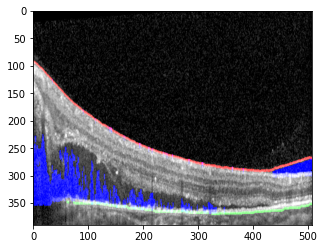

Length is  451 cropped_DH022.tif
RPE VALS  [156, 157, 155, 156, 157, 158, 156, 157, 162, 163, 162, 163, 162, 163, 166, 165, 166, 167, 165, 166, 187, 188, 173, 174, 186, 187, 188, 173, 174, 175, 187, 188, 183, 184, 185, 193, 182, 183, 184, 185, 186, 193, 182, 183, 184, 185, 183, 184, 190, 191, 192, 189, 190, 191, 192, 193, 181, 182, 188, 189, 190, 191, 192, 181, 182, 189, 182, 197, 198, 199, 196, 197, 198, 199, 200, 201, 196, 197, 198, 194, 195, 196, 194, 195, 194, 328, 328, 329, 332, 332, 336, 336, 338, 337, 338, 339, 338, 339, 338, 339, 340, 339, 340, 348, 349, 245, 246, 348, 349, 350, 245, 249, 349, 249, 351, 358, 358, 358, 359, 360, 286, 286, 364, 364, 365, 364, 365, 366, 364, 365, 366, 364, 365, 366, 288, 289, 363, 364, 365, 366, 367, 288, 289, 363, 364, 365, 366, 367, 364, 365, 366, 367, 364, 365, 366, 367, 364, 365, 366, 367, 296, 297, 364, 365, 366, 367, 294, 295, 296, 297, 298, 364, 365, 366, 367, 293, 294, 295, 296, 297, 298, 364, 365, 366, 367, 287, 288, 289, 293, 294, 364, 3

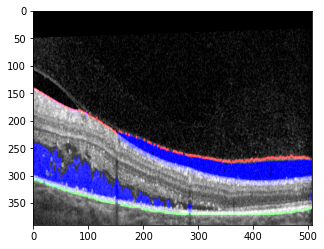

Length is  456 cropped_DH021.tif
RPE VALS  [164, 163, 164, 165, 164, 168, 167, 168, 169, 168, 169, 170, 174, 181, 169, 170, 172, 173, 174, 175, 181, 182, 170, 171, 172, 173, 174, 175, 181, 182, 182, 182, 171, 172, 173, 172, 173, 179, 180, 173, 178, 179, 180, 173, 174, 175, 177, 178, 179, 180, 175, 176, 177, 178, 179, 175, 176, 177, 328, 329, 328, 329, 330, 329, 330, 329, 330, 330, 331, 331, 332, 331, 332, 335, 336, 334, 335, 336, 335, 336, 337, 338, 336, 337, 338, 337, 338, 206, 207, 206, 207, 208, 342, 343, 342, 343, 344, 342, 343, 344, 343, 351, 352, 353, 357, 357, 357, 358, 356, 357, 358, 359, 357, 358, 358, 359, 358, 359, 359, 360, 358, 359, 360, 359, 360, 361, 362, 363, 360, 361, 362, 363, 361, 361, 362, 279, 277, 363, 364, 365, 363, 364, 365, 363, 364, 365, 363, 364, 365, 363, 364, 365, 366, 364, 365, 282, 283, 282, 287, 287, 364, 363, 364, 365, 283, 284, 364, 283, 284, 286, 287, 286, 287, 365, 365, 366, 364, 365, 366, 364, 365, 363, 364, 363, 287, 288, 289, 286, 287, 288, 289, 2

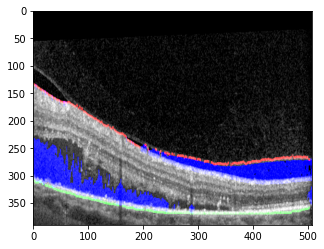

Length is  488 cropped_DH020.tif
RPE VALS  [236, 237, 238, 237, 327, 327, 330, 330, 185, 335, 336, 334, 335, 336, 335, 193, 194, 338, 339, 338, 339, 340, 339, 340, 339, 340, 341, 341, 340, 341, 340, 341, 339, 340, 341, 340, 341, 238, 239, 240, 241, 242, 243, 244, 245, 237, 238, 239, 240, 241, 242, 243, 244, 245, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 238, 239, 240, 241, 242, 243, 244, 245, 344, 344, 243, 244, 243, 244, 243, 244, 347, 346, 347, 348, 347, 347, 347, 351, 352, 351, 352, 353, 351, 352, 353, 354, 352, 353, 354, 355, 355, 354, 355, 354, 355, 356, 355, 356, 359, 359, 366, 367, 368, 365, 366, 367, 364, 365, 366, 367, 365, 366, 367, 365, 366, 367, 365, 366, 367, 365, 366, 367, 366, 365, 366, 367, 368, 365, 366, 367, 368, 365, 366, 367, 368, 366, 366, 367, 367, 368, 367, 368, 369, 366, 367, 368, 369, 365, 366, 367, 368, 3

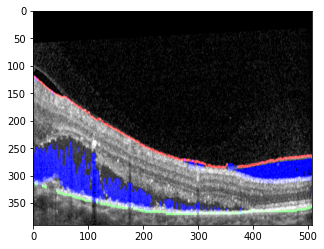

Length is  459 cropped_DH023.tif
RPE VALS  [167, 168, 171, 172, 167, 168, 169, 170, 171, 172, 173, 168, 169, 170, 171, 172, 169, 170, 171, 172, 173, 170, 171, 172, 173, 176, 177, 178, 177, 187, 188, 190, 187, 188, 189, 190, 191, 190, 183, 184, 183, 184, 185, 183, 184, 185, 186, 187, 188, 189, 187, 188, 189, 190, 318, 318, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 205, 206, 207, 208, 207, 208, 209, 322, 322, 322, 203, 204, 205, 202, 203, 204, 205, 206, 202, 203, 204, 205, 210, 211, 210, 211, 326, 327, 326, 327, 197, 197, 197, 329, 330, 329, 330, 330, 202, 203, 201, 202, 203, 202, 203, 215, 212, 213, 214, 215, 223, 224, 211, 212, 213, 214, 223, 224, 212, 213, 337, 338, 339, 337, 338, 339, 343, 344, 343, 344, 343, 344, 343, 344, 345, 344, 345, 344, 350, 350, 352, 352, 353, 354, 355, 354, 355, 356, 356, 357, 359, 360, 359, 360, 358, 359, 360, 359, 360, 359, 360, 361, 361, 288, 362, 363, 362, 363, 364, 3

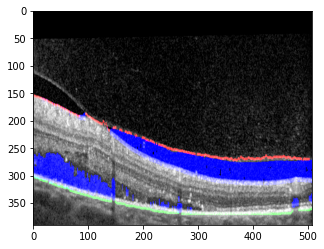

Length is  497 cropped_DH019.tif
RPE VALS  [200, 199, 200, 201, 200, 201, 156, 156, 157, 187, 188, 187, 188, 339, 338, 339, 340, 339, 340, 340, 341, 342, 231, 232, 233, 231, 232, 233, 234, 235, 236, 237, 231, 232, 233, 234, 235, 236, 237, 342, 342, 341, 342, 343, 342, 343, 344, 343, 344, 345, 343, 344, 345, 342, 343, 344, 345, 342, 343, 344, 345, 343, 344, 345, 345, 345, 346, 345, 346, 347, 348, 349, 347, 348, 349, 348, 349, 348, 349, 348, 349, 350, 348, 349, 350, 348, 349, 350, 351, 352, 350, 351, 352, 353, 351, 352, 353, 354, 351, 352, 353, 352, 353, 353, 354, 352, 353, 354, 352, 353, 354, 352, 353, 354, 353, 354, 354, 354, 353, 354, 353, 359, 360, 359, 360, 250, 251, 250, 251, 250, 356, 356, 360, 359, 360, 359, 360, 360, 361, 360, 361, 360, 361, 278, 278, 362, 366, 283, 284, 283, 284, 282, 283, 366, 367, 368, 365, 366, 367, 368, 365, 366, 285, 286, 285, 286, 287, 287, 289, 290, 289, 290, 290, 291, 288, 288, 367, 368, 367, 368, 369, 367, 368, 369, 367, 368, 292, 293, 293, 293, 366, 3

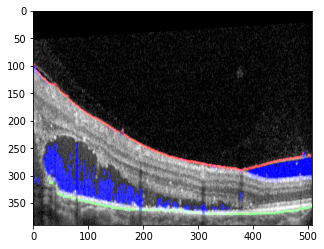

Length is  507 cropped_JB000.bmp
RPE VALS  [193, 193, 193, 194, 193, 194, 208, 209, 207, 208, 209, 207, 208, 209, 210, 207, 208, 209, 210, 208, 209, 210, 212, 211, 212, 213, 211, 212, 211, 212, 213, 214, 215, 213, 214, 215, 209, 210, 211, 212, 213, 214, 209, 210, 213, 214, 212, 212, 213, 212, 213, 214, 213, 214, 215, 217, 216, 217, 218, 217, 218, 217, 218, 219, 218, 218, 219, 217, 218, 219, 220, 216, 217, 218, 219, 217, 218, 219, 218, 218, 219, 217, 218, 219, 217, 218, 219, 216, 217, 218, 217, 216, 217, 216, 217, 216, 217, 216, 217, 216, 217, 216, 217, 218, 215, 216, 217, 216, 217, 218, 219, 216, 217, 218, 219, 216, 217, 218, 216, 217, 218, 216, 217, 218, 214, 215, 216, 217, 218, 219, 214, 215, 216, 217, 218, 219, 214, 215, 216, 217, 218, 219, 214, 215, 216, 217, 218, 219, 215, 215, 216, 215, 216, 217, 218, 215, 216, 217, 218, 215, 216, 217, 214, 215, 216, 213, 214, 215, 216, 213, 214, 215, 213, 214, 215, 214, 215, 214, 215, 216, 214, 215, 216, 213, 214, 215, 213, 214, 215, 212, 213, 2

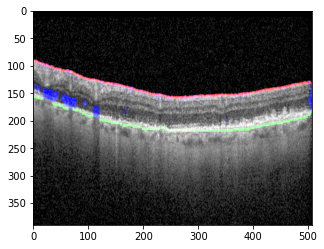

Length is  508 cropped_JB001.bmp
RPE VALS  [96, 95, 96, 96, 186, 187, 186, 187, 187, 186, 187, 188, 187, 191, 192, 190, 191, 192, 193, 191, 192, 177, 178, 179, 177, 178, 179, 177, 178, 177, 177, 206, 207, 206, 207, 208, 207, 208, 209, 208, 209, 207, 208, 209, 208, 209, 209, 210, 211, 209, 210, 211, 209, 210, 211, 210, 211, 212, 213, 211, 212, 213, 211, 212, 213, 211, 212, 213, 211, 212, 213, 211, 212, 213, 214, 212, 213, 212, 213, 214, 212, 213, 211, 212, 211, 212, 213, 214, 212, 213, 214, 213, 214, 215, 214, 215, 216, 215, 216, 214, 215, 216, 217, 214, 215, 216, 217, 215, 216, 217, 215, 216, 215, 216, 214, 215, 216, 214, 215, 216, 214, 215, 216, 215, 216, 217, 215, 216, 217, 215, 216, 217, 218, 215, 216, 217, 218, 216, 217, 218, 217, 218, 216, 217, 218, 216, 217, 218, 216, 217, 218, 216, 217, 218, 219, 216, 217, 218, 219, 216, 217, 218, 216, 217, 217, 215, 216, 216, 208, 209, 210, 205, 206, 207, 208, 204, 205, 206, 207, 208, 204, 205, 206, 207, 208, 205, 206, 207, 208, 209, 206, 207, 

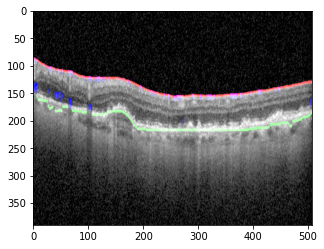

Length is  508 cropped_JB003.bmp
RPE VALS  [98, 98, 178, 179, 180, 176, 177, 178, 179, 180, 175, 176, 177, 178, 179, 175, 176, 177, 178, 179, 176, 177, 178, 179, 180, 177, 178, 179, 180, 181, 178, 179, 180, 181, 178, 179, 180, 181, 179, 180, 181, 182, 179, 180, 181, 182, 179, 180, 181, 182, 179, 180, 181, 182, 180, 181, 180, 181, 176, 173, 174, 175, 173, 174, 175, 171, 172, 173, 168, 169, 170, 171, 167, 168, 169, 170, 167, 168, 169, 167, 168, 167, 160, 160, 152, 153, 151, 152, 153, 154, 151, 152, 153, 154, 150, 151, 152, 153, 149, 147, 148, 149, 150, 146, 147, 148, 149, 146, 147, 148, 146, 147, 144, 145, 143, 144, 145, 146, 147, 143, 144, 145, 146, 147, 143, 144, 145, 146, 144, 145, 146, 144, 145, 146, 144, 145, 146, 142, 143, 141, 142, 143, 141, 142, 143, 142, 143, 145, 146, 144, 145, 146, 147, 144, 145, 146, 147, 148, 147, 145, 145, 147, 148, 149, 148, 149, 148, 149, 168, 167, 168, 169, 167, 168, 169, 170, 167, 168, 169, 170, 176, 177, 178, 179, 176, 177, 178, 179, 180, 177, 178, 179

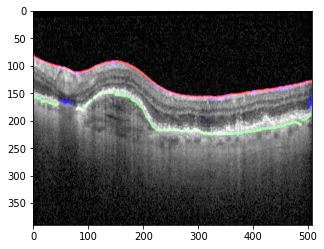

Length is  508 cropped_JB002.bmp
RPE VALS  [150, 150, 153, 154, 153, 154, 155, 154, 156, 157, 157, 159, 160, 161, 160, 161, 162, 160, 161, 170, 171, 169, 170, 171, 172, 168, 169, 170, 171, 168, 169, 170, 167, 168, 169, 168, 169, 166, 167, 168, 165, 166, 167, 168, 165, 166, 167, 168, 165, 166, 167, 168, 165, 166, 167, 166, 167, 166, 167, 166, 167, 166, 167, 168, 165, 166, 167, 166, 167, 165, 165, 169, 163, 158, 159, 160, 159, 160, 161, 159, 160, 161, 159, 160, 161, 157, 158, 159, 160, 161, 157, 158, 159, 160, 161, 157, 158, 159, 160, 157, 158, 159, 160, 156, 157, 158, 159, 160, 161, 162, 155, 156, 157, 158, 161, 162, 156, 157, 158, 159, 158, 159, 160, 158, 159, 160, 161, 159, 160, 161, 160, 160, 159, 160, 159, 160, 161, 159, 160, 161, 159, 160, 161, 162, 162, 165, 166, 165, 166, 164, 165, 167, 168, 166, 167, 168, 167, 169, 170, 170, 181, 182, 183, 181, 182, 183, 184, 183, 184, 185, 189, 190, 191, 189, 190, 191, 192, 190, 191, 192, 193, 204, 204, 208, 209, 208, 210, 211, 212, 210, 211, 2

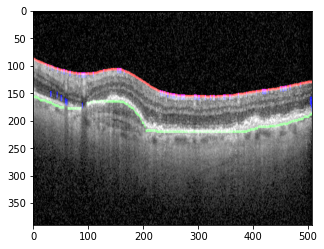

Length is  491 cropped_DH024.tif
RPE VALS  [172, 176, 177, 178, 176, 177, 178, 179, 178, 179, 192, 193, 190, 191, 192, 193, 194, 191, 192, 193, 199, 199, 198, 199, 200, 201, 201, 202, 200, 201, 202, 198, 199, 202, 198, 199, 188, 194, 185, 186, 187, 188, 189, 193, 194, 195, 196, 197, 185, 186, 187, 188, 192, 193, 194, 195, 196, 197, 198, 185, 186, 187, 193, 194, 195, 196, 197, 185, 206, 207, 206, 207, 206, 198, 198, 192, 192, 193, 318, 319, 319, 252, 253, 220, 221, 207, 220, 221, 207, 212, 213, 218, 207, 211, 212, 213, 217, 218, 211, 212, 213, 214, 215, 216, 217, 218, 207, 208, 209, 212, 213, 214, 215, 216, 217, 218, 219, 208, 209, 218, 209, 210, 223, 223, 325, 325, 217, 218, 216, 217, 218, 212, 215, 216, 217, 218, 212, 213, 206, 206, 212, 213, 211, 212, 213, 209, 209, 217, 218, 217, 221, 220, 221, 222, 219, 220, 221, 222, 219, 220, 221, 222, 223, 220, 221, 222, 223, 220, 221, 222, 223, 220, 221, 222, 219, 220, 221, 220, 220, 220, 220, 232, 233, 231, 232, 233, 234, 227, 231, 232, 233, 2

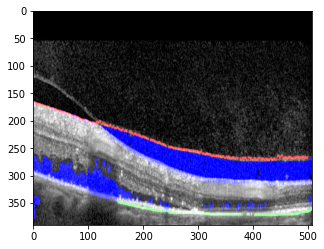

Length is  508 cropped_JB007.bmp
RPE VALS  [86, 87, 88, 86, 87, 146, 147, 146, 147, 114, 113, 114, 115, 114, 154, 155, 155, 155, 155, 154, 155, 156, 157, 154, 155, 156, 157, 158, 154, 155, 156, 157, 154, 155, 156, 157, 155, 156, 157, 156, 157, 158, 157, 158, 159, 158, 159, 160, 159, 160, 161, 159, 160, 161, 162, 159, 160, 161, 162, 159, 160, 161, 162, 159, 160, 161, 162, 159, 160, 161, 162, 160, 161, 162, 161, 162, 163, 164, 165, 162, 163, 164, 165, 166, 162, 163, 164, 165, 166, 163, 164, 165, 166, 167, 164, 165, 166, 167, 165, 166, 167, 165, 166, 167, 168, 165, 166, 167, 166, 170, 171, 170, 171, 172, 182, 183, 171, 172, 182, 183, 184, 185, 172, 173, 183, 184, 185, 171, 172, 173, 174, 184, 185, 172, 173, 174, 175, 185, 186, 173, 174, 175, 184, 185, 186, 174, 175, 184, 185, 186, 174, 175, 184, 185, 186, 173, 174, 175, 185, 173, 174, 175, 176, 173, 174, 175, 176, 121, 174, 175, 176, 177, 120, 121, 174, 175, 176, 177, 120, 121, 174, 175, 176, 177, 178, 173, 174, 175, 176, 177, 173, 174, 1

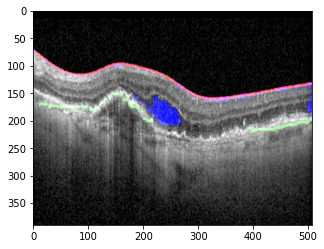

Length is  508 cropped_JB006.bmp
RPE VALS  [92, 146, 92, 146, 148, 148, 149, 93, 94, 150, 151, 93, 94, 150, 151, 152, 150, 151, 153, 154, 152, 153, 154, 155, 153, 154, 153, 154, 152, 153, 154, 155, 152, 153, 154, 155, 153, 154, 155, 153, 154, 155, 154, 155, 154, 155, 156, 155, 156, 157, 158, 156, 157, 158, 159, 159, 160, 159, 160, 161, 162, 158, 159, 160, 161, 162, 159, 160, 161, 162, 160, 161, 161, 162, 162, 164, 165, 166, 164, 165, 166, 167, 168, 165, 166, 167, 168, 169, 166, 167, 168, 169, 170, 171, 165, 166, 167, 168, 169, 170, 171, 165, 169, 170, 171, 164, 165, 166, 167, 169, 165, 166, 167, 168, 169, 170, 166, 167, 168, 169, 170, 171, 166, 167, 168, 169, 170, 171, 172, 173, 166, 167, 168, 169, 170, 171, 173, 174, 166, 167, 168, 169, 170, 171, 173, 174, 175, 167, 168, 169, 170, 171, 174, 175, 168, 169, 170, 171, 172, 174, 175, 169, 170, 171, 170, 171, 172, 170, 171, 172, 170, 171, 172, 173, 186, 170, 171, 172, 186, 169, 170, 171, 172, 168, 169, 170, 171, 172, 173, 167, 168, 169, 17

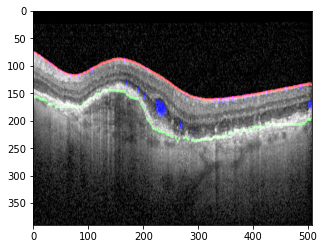

Length is  508 cropped_JB004.bmp
RPE VALS  [149, 150, 151, 150, 163, 164, 163, 164, 164, 165, 165, 166, 165, 166, 167, 165, 166, 167, 166, 167, 168, 166, 167, 168, 166, 167, 168, 169, 166, 167, 168, 169, 166, 167, 168, 169, 167, 168, 169, 172, 171, 172, 170, 169, 170, 170, 171, 170, 171, 172, 173, 170, 171, 172, 173, 174, 170, 171, 172, 173, 170, 171, 172, 173, 174, 171, 172, 173, 172, 173, 174, 173, 174, 173, 174, 175, 173, 174, 175, 173, 174, 175, 176, 174, 175, 176, 170, 171, 172, 169, 170, 171, 172, 173, 174, 175, 169, 170, 171, 172, 173, 174, 175, 169, 170, 172, 173, 174, 175, 172, 173, 174, 172, 173, 174, 172, 173, 164, 165, 161, 162, 163, 164, 161, 162, 163, 164, 162, 163, 158, 159, 158, 159, 157, 158, 157, 158, 157, 158, 159, 160, 157, 158, 159, 160, 158, 159, 155, 156, 153, 154, 155, 153, 154, 155, 152, 153, 154, 151, 152, 153, 154, 151, 152, 153, 154, 145, 144, 145, 146, 143, 144, 145, 144, 143, 142, 143, 142, 143, 141, 142, 143, 141, 142, 143, 144, 139, 140, 141, 143, 144, 1

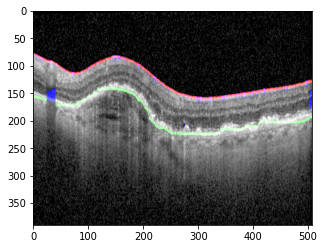

Length is  507 cropped_JB005.bmp
RPE VALS  [160, 161, 162, 161, 162, 163, 162, 163, 164, 161, 162, 163, 164, 161, 162, 163, 164, 165, 161, 162, 163, 164, 162, 163, 164, 162, 163, 164, 163, 164, 165, 164, 165, 166, 165, 166, 165, 166, 163, 164, 165, 166, 167, 168, 163, 164, 165, 166, 167, 168, 162, 163, 164, 165, 166, 167, 168, 123, 163, 164, 165, 166, 122, 123, 124, 164, 165, 166, 123, 164, 165, 166, 167, 164, 165, 166, 167, 168, 164, 165, 166, 167, 164, 165, 166, 167, 164, 165, 166, 167, 164, 165, 166, 167, 165, 166, 167, 168, 165, 166, 167, 168, 169, 166, 169, 170, 171, 169, 170, 171, 172, 169, 170, 171, 172, 173, 169, 170, 171, 172, 174, 175, 174, 175, 176, 173, 173, 174, 175, 176, 177, 175, 176, 177, 177, 178, 172, 173, 174, 175, 176, 177, 178, 179, 172, 173, 174, 175, 176, 177, 178, 179, 176, 177, 178, 179, 180, 177, 178, 179, 180, 178, 179, 180, 173, 168, 169, 167, 168, 169, 167, 168, 166, 167, 165, 166, 167, 164, 165, 166, 163, 164, 165, 166, 163, 164, 165, 163, 164, 165, 162, 1

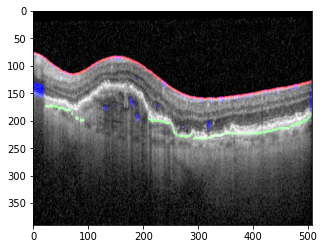

Length is  508 cropped_JB012.bmp
RPE VALS  [90, 143, 144, 145, 146, 90, 144, 145, 146, 147, 144, 145, 146, 147, 91, 92, 145, 146, 147, 148, 91, 92, 93, 145, 146, 147, 148, 149, 91, 92, 93, 144, 145, 146, 147, 148, 149, 91, 92, 93, 94, 144, 145, 146, 147, 148, 92, 93, 94, 145, 146, 147, 148, 155, 156, 91, 92, 93, 94, 146, 147, 148, 149, 150, 155, 156, 91, 92, 93, 94, 147, 148, 149, 150, 151, 88, 91, 92, 93, 147, 148, 149, 150, 87, 88, 89, 90, 91, 92, 93, 147, 148, 149, 150, 87, 88, 89, 90, 91, 92, 148, 149, 150, 88, 89, 90, 91, 92, 148, 149, 150, 149, 150, 149, 150, 151, 151, 152, 151, 152, 153, 154, 151, 152, 153, 154, 152, 153, 154, 155, 152, 153, 154, 152, 153, 154, 153, 154, 155, 153, 154, 155, 156, 157, 153, 154, 155, 156, 157, 153, 154, 155, 156, 154, 155, 156, 155, 156, 157, 156, 157, 158, 157, 158, 159, 159, 153, 154, 155, 156, 157, 155, 156, 157, 156, 157, 156, 157, 158, 159, 156, 157, 158, 159, 160, 157, 158, 159, 160, 156, 157, 155, 156, 157, 158, 162, 163, 164, 153, 154, 155

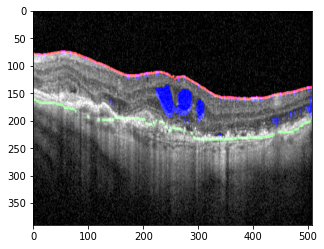

Length is  505 cropped_JB008.bmp
RPE VALS  [141, 142, 143, 142, 143, 88, 142, 143, 144, 88, 89, 143, 144, 88, 89, 90, 88, 89, 90, 91, 89, 90, 91, 149, 150, 151, 149, 150, 151, 152, 151, 152, 154, 155, 156, 157, 154, 155, 156, 157, 155, 156, 157, 158, 155, 156, 157, 158, 155, 156, 157, 158, 156, 157, 158, 157, 158, 157, 156, 157, 158, 157, 158, 159, 158, 159, 158, 159, 160, 157, 158, 159, 160, 161, 162, 157, 158, 159, 160, 161, 162, 163, 158, 159, 160, 161, 162, 163, 158, 159, 160, 161, 162, 163, 159, 160, 161, 162, 163, 167, 161, 162, 163, 166, 167, 168, 169, 163, 164, 167, 168, 163, 164, 163, 164, 163, 164, 165, 110, 164, 165, 166, 167, 110, 111, 164, 165, 166, 110, 111, 164, 165, 166, 167, 164, 165, 166, 167, 166, 167, 166, 166, 167, 165, 166, 167, 168, 166, 167, 168, 169, 167, 168, 169, 167, 168, 169, 166, 167, 168, 169, 170, 166, 167, 168, 169, 170, 166, 167, 168, 169, 170, 171, 165, 166, 167, 168, 169, 170, 171, 172, 169, 170, 171, 172, 173, 171, 172, 173, 174, 171, 172, 173, 174,

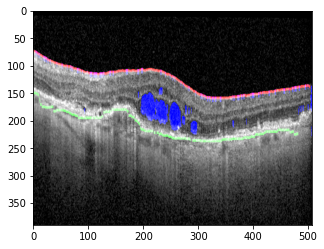

Length is  507 cropped_JB009.bmp
RPE VALS  [147, 148, 147, 148, 147, 148, 93, 148, 149, 148, 149, 150, 151, 148, 149, 150, 151, 149, 150, 151, 150, 151, 154, 153, 154, 155, 153, 154, 155, 156, 154, 155, 156, 95, 95, 159, 160, 163, 164, 158, 159, 160, 161, 162, 163, 164, 158, 159, 160, 161, 162, 163, 98, 100, 159, 160, 161, 162, 96, 97, 98, 99, 100, 101, 159, 160, 161, 162, 163, 97, 98, 99, 100, 101, 159, 160, 161, 162, 163, 99, 100, 160, 161, 162, 163, 159, 160, 161, 162, 163, 158, 159, 160, 161, 162, 163, 164, 158, 159, 160, 161, 162, 163, 164, 99, 100, 163, 164, 165, 99, 163, 164, 165, 166, 94, 95, 163, 164, 165, 166, 167, 93, 94, 95, 96, 159, 162, 163, 164, 165, 166, 167, 94, 95, 96, 97, 158, 159, 160, 161, 162, 163, 164, 165, 166, 95, 96, 97, 159, 160, 161, 162, 163, 164, 165, 166, 159, 160, 161, 162, 163, 164, 178, 159, 160, 161, 162, 178, 159, 160, 161, 162, 163, 161, 162, 163, 164, 162, 163, 164, 165, 162, 163, 164, 165, 167, 163, 164, 165, 166, 167, 164, 165, 95, 94, 95, 172, 1

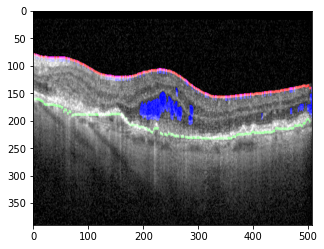

Length is  506 cropped_JB011.bmp
RPE VALS  [145, 146, 147, 148, 149, 92, 145, 146, 147, 148, 149, 150, 146, 147, 148, 149, 150, 89, 90, 91, 92, 93, 145, 146, 147, 148, 89, 90, 91, 92, 93, 146, 147, 148, 91, 92, 93, 146, 147, 148, 147, 148, 149, 148, 149, 150, 149, 150, 158, 159, 160, 94, 95, 150, 151, 158, 159, 160, 94, 95, 96, 151, 152, 95, 152, 151, 152, 153, 152, 153, 152, 153, 153, 154, 155, 153, 154, 155, 154, 155, 154, 155, 156, 157, 158, 153, 154, 155, 156, 157, 152, 153, 154, 155, 151, 152, 153, 154, 152, 153, 160, 173, 174, 175, 172, 173, 174, 175, 173, 174, 175, 159, 160, 145, 146, 168, 169, 172, 173, 171, 172, 173, 171, 172, 175, 175, 174, 175, 174, 172, 173, 174, 175, 169, 170, 171, 172, 173, 174, 175, 176, 169, 170, 171, 172, 173, 174, 175, 173, 174, 173, 173, 178, 177, 178, 179, 178, 179, 177, 178, 173, 174, 175, 176, 177, 178, 173, 174, 175, 176, 177, 178, 179, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 174, 175, 176, 177, 179, 180, 181, 182, 183, 175, 176, 177, 1

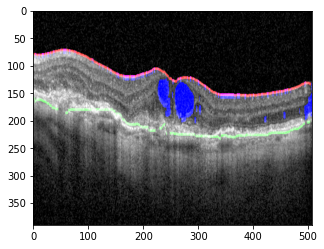

Length is  507 cropped_JB010.bmp
RPE VALS  [89, 90, 91, 147, 148, 90, 91, 92, 93, 147, 148, 149, 90, 91, 92, 93, 94, 96, 97, 147, 148, 149, 150, 91, 92, 93, 96, 97, 148, 149, 150, 151, 92, 96, 97, 148, 149, 150, 151, 152, 96, 149, 150, 151, 152, 84, 85, 150, 151, 152, 83, 84, 85, 88, 89, 90, 91, 92, 93, 150, 151, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 150, 151, 83, 84, 85, 89, 90, 91, 92, 93, 150, 151, 152, 83, 84, 85, 92, 150, 151, 152, 153, 151, 152, 153, 154, 87, 152, 153, 154, 87, 88, 153, 154, 87, 88, 98, 153, 154, 88, 89, 98, 153, 154, 89, 153, 154, 154, 155, 155, 93, 158, 158, 159, 160, 161, 159, 160, 161, 158, 159, 160, 161, 157, 158, 159, 160, 161, 158, 159, 160, 161, 162, 158, 159, 160, 161, 162, 158, 159, 160, 161, 162, 163, 157, 158, 159, 160, 161, 162, 156, 157, 158, 159, 160, 161, 162, 83, 156, 157, 158, 159, 160, 161, 162, 82, 83, 84, 156, 157, 158, 159, 160, 161, 83, 84, 152, 156, 157, 158, 159, 138, 139, 152, 153, 156, 157, 158, 138, 139, 152, 153, 155, 156, 155, 

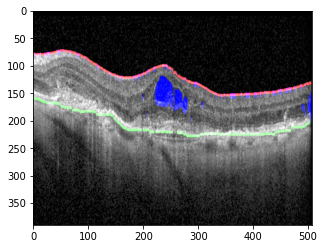

Length is  507 cropped_JB014.bmp
RPE VALS  [139, 140, 141, 149, 150, 150, 139, 140, 141, 142, 139, 140, 141, 142, 143, 149, 150, 151, 140, 141, 142, 143, 148, 149, 150, 151, 140, 141, 142, 143, 149, 150, 143, 143, 142, 143, 144, 93, 94, 141, 142, 143, 144, 93, 140, 141, 142, 143, 140, 141, 142, 143, 91, 92, 141, 142, 143, 152, 153, 154, 155, 89, 90, 91, 92, 142, 143, 144, 145, 152, 153, 154, 155, 89, 90, 91, 143, 144, 145, 88, 89, 90, 89, 146, 147, 146, 147, 148, 147, 148, 149, 147, 148, 149, 150, 148, 149, 150, 151, 148, 149, 150, 151, 148, 149, 150, 151, 149, 150, 158, 159, 160, 158, 159, 160, 161, 158, 159, 160, 161, 162, 159, 160, 161, 162, 163, 161, 162, 154, 153, 154, 155, 154, 157, 156, 157, 158, 157, 156, 157, 154, 155, 156, 157, 158, 155, 156, 157, 158, 159, 156, 157, 158, 159, 160, 161, 159, 160, 161, 162, 160, 161, 162, 163, 162, 163, 163, 164, 163, 164, 165, 164, 165, 169, 165, 166, 167, 164, 165, 166, 167, 164, 165, 166, 167, 164, 165, 166, 167, 163, 164, 165, 166, 167, 16

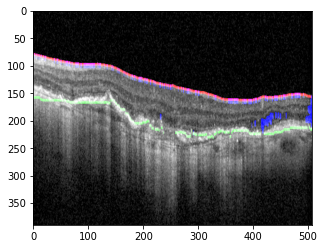

Length is  508 cropped_JB013.bmp
RPE VALS  [91, 92, 93, 148, 149, 150, 151, 91, 143, 144, 149, 150, 151, 152, 89, 90, 91, 92, 142, 143, 144, 145, 150, 151, 152, 89, 90, 91, 92, 142, 143, 144, 145, 151, 90, 91, 92, 143, 144, 145, 146, 143, 144, 145, 146, 143, 144, 145, 143, 144, 145, 143, 144, 145, 144, 145, 146, 152, 153, 144, 145, 146, 153, 154, 145, 153, 154, 150, 151, 150, 151, 152, 153, 151, 152, 153, 154, 150, 151, 152, 153, 154, 148, 149, 152, 153, 148, 149, 152, 153, 153, 154, 153, 154, 153, 154, 154, 161, 162, 158, 159, 160, 158, 159, 160, 158, 159, 160, 158, 159, 160, 173, 174, 158, 159, 160, 158, 159, 160, 161, 162, 159, 160, 161, 160, 161, 160, 161, 162, 161, 162, 163, 161, 162, 163, 159, 160, 161, 162, 163, 159, 160, 161, 162, 160, 161, 162, 169, 170, 165, 166, 167, 168, 169, 170, 165, 166, 167, 168, 169, 170, 171, 165, 166, 167, 168, 169, 170, 171, 172, 166, 167, 168, 169, 170, 171, 172, 166, 167, 168, 169, 170, 171, 172, 166, 167, 168, 169, 170, 171, 172, 166, 167, 168, 1

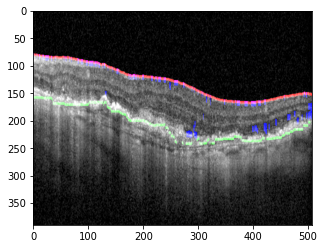

Length is  508 cropped_JB015.bmp
RPE VALS  [83, 84, 85, 135, 136, 137, 138, 139, 140, 145, 146, 147, 148, 149, 150, 151, 152, 83, 84, 85, 136, 137, 138, 139, 140, 145, 146, 147, 148, 149, 150, 151, 83, 84, 85, 137, 138, 139, 140, 141, 146, 147, 148, 149, 150, 84, 138, 139, 140, 141, 142, 146, 147, 148, 149, 150, 138, 139, 140, 141, 142, 147, 148, 149, 137, 138, 139, 140, 141, 142, 147, 148, 149, 137, 138, 139, 140, 141, 142, 148, 137, 138, 139, 140, 141, 142, 138, 139, 140, 141, 142, 143, 138, 139, 140, 141, 142, 143, 139, 140, 141, 142, 143, 139, 140, 141, 142, 143, 144, 140, 141, 142, 143, 144, 141, 142, 143, 144, 142, 143, 144, 142, 143, 144, 145, 142, 143, 144, 145, 146, 143, 144, 145, 146, 147, 152, 153, 144, 145, 146, 147, 152, 153, 154, 145, 146, 153, 154, 144, 145, 146, 143, 144, 145, 146, 147, 142, 143, 144, 145, 146, 147, 141, 142, 143, 144, 145, 146, 147, 148, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 138, 139, 140, 141, 142, 143, 146, 147, 138, 139, 140, 141, 142, 1

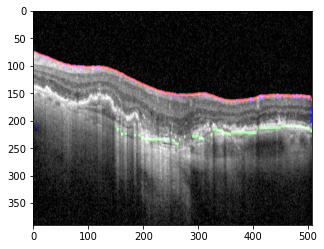

Length is  508 cropped_JB017.bmp
RPE VALS  [87, 88, 89, 90, 136, 137, 138, 139, 144, 145, 146, 86, 87, 88, 89, 90, 135, 136, 137, 138, 145, 146, 86, 87, 88, 89, 90, 135, 136, 137, 138, 86, 87, 88, 89, 90, 91, 135, 136, 137, 138, 139, 87, 88, 89, 90, 91, 135, 136, 137, 138, 139, 140, 88, 89, 90, 91, 136, 137, 138, 139, 140, 90, 91, 137, 138, 139, 140, 138, 139, 140, 138, 139, 140, 139, 140, 141, 139, 140, 141, 83, 84, 91, 92, 138, 139, 140, 141, 83, 90, 91, 92, 93, 139, 140, 141, 90, 91, 92, 93, 140, 141, 91, 92, 93, 141, 142, 141, 142, 143, 142, 143, 144, 142, 143, 144, 145, 154, 142, 143, 144, 145, 154, 155, 156, 142, 143, 144, 145, 146, 154, 155, 156, 157, 143, 144, 145, 146, 154, 155, 156, 157, 158, 159, 143, 144, 145, 146, 155, 156, 157, 158, 159, 160, 142, 143, 144, 145, 146, 147, 148, 149, 157, 158, 159, 160, 143, 144, 145, 146, 147, 148, 149, 144, 145, 146, 147, 148, 149, 145, 146, 147, 148, 149, 146, 147, 148, 149, 147, 148, 149, 147, 148, 149, 150, 151, 147, 148, 149, 150, 151

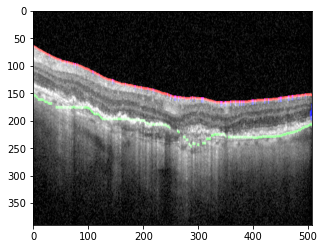

Length is  508 cropped_JB018.bmp
RPE VALS  [78, 102, 103, 80, 81, 81, 82, 81, 82, 82, 83, 83, 84, 82, 83, 84, 85, 82, 83, 84, 85, 82, 83, 84, 85, 86, 81, 82, 83, 84, 85, 86, 81, 82, 83, 84, 85, 86, 87, 81, 82, 83, 84, 85, 86, 87, 83, 84, 85, 86, 87, 84, 85, 86, 87, 88, 85, 86, 87, 88, 79, 80, 87, 79, 80, 86, 87, 84, 85, 86, 87, 84, 85, 153, 154, 155, 156, 152, 153, 154, 155, 156, 151, 152, 153, 154, 155, 156, 152, 153, 154, 155, 156, 155, 156, 155, 156, 157, 155, 156, 157, 154, 155, 156, 157, 158, 159, 108, 155, 156, 157, 158, 159, 108, 158, 159, 158, 159, 153, 154, 155, 156, 157, 158, 159, 160, 153, 154, 155, 156, 157, 158, 159, 154, 155, 156, 157, 158, 154, 155, 156, 157, 158, 173, 155, 156, 157, 158, 173, 156, 157, 158, 159, 157, 158, 159, 162, 163, 164, 165, 161, 162, 163, 164, 165, 166, 162, 163, 164, 165, 166, 162, 163, 164, 165, 166, 163, 164, 165, 164, 166, 167, 166, 167, 164, 165, 161, 162, 163, 164, 165, 166, 160, 161, 162, 163, 164, 165, 166, 161, 162, 163, 164, 165, 166, 16

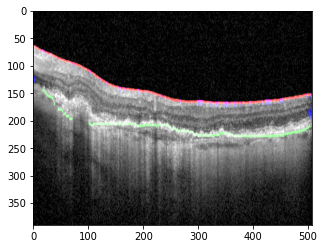

Length is  508 cropped_JB016.bmp
RPE VALS  [88, 89, 90, 91, 92, 93, 135, 136, 137, 138, 139, 88, 89, 90, 91, 92, 93, 136, 137, 138, 139, 89, 90, 91, 92, 93, 136, 137, 138, 90, 91, 92, 136, 137, 138, 137, 138, 139, 140, 138, 139, 140, 138, 139, 140, 141, 139, 140, 141, 139, 140, 141, 142, 139, 140, 141, 142, 93, 94, 95, 140, 141, 142, 143, 94, 140, 141, 142, 143, 140, 141, 142, 143, 141, 142, 143, 144, 143, 144, 145, 142, 143, 144, 145, 146, 143, 144, 145, 146, 147, 143, 144, 145, 146, 147, 143, 144, 145, 146, 147, 144, 145, 146, 147, 148, 144, 145, 146, 147, 148, 143, 144, 145, 146, 147, 148, 157, 158, 100, 101, 142, 143, 144, 145, 156, 157, 158, 99, 100, 101, 142, 143, 144, 145, 157, 158, 99, 100, 101, 142, 143, 144, 145, 146, 147, 148, 149, 142, 143, 144, 145, 146, 147, 148, 149, 143, 144, 145, 146, 147, 148, 149, 144, 145, 146, 147, 148, 149, 146, 147, 148, 149, 150, 146, 147, 148, 149, 150, 151, 145, 146, 147, 148, 149, 150, 151, 144, 145, 146, 147, 148, 149, 150, 151, 144, 145, 14

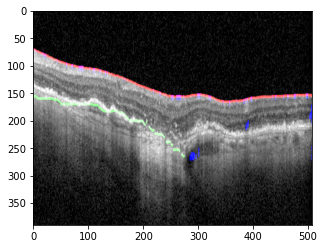

Length is  508 cropped_JB020.bmp
RPE VALS  [133, 134, 133, 134, 135, 134, 135, 136, 134, 135, 136, 137, 136, 137, 136, 137, 138, 136, 137, 138, 136, 137, 138, 139, 136, 137, 138, 139, 140, 137, 138, 139, 140, 138, 139, 140, 138, 139, 140, 138, 139, 140, 138, 139, 140, 138, 139, 140, 139, 140, 139, 140, 139, 140, 141, 142, 143, 140, 141, 142, 143, 140, 141, 142, 143, 141, 142, 143, 141, 142, 143, 144, 142, 143, 144, 142, 143, 144, 145, 146, 143, 144, 145, 146, 147, 144, 145, 146, 147, 144, 145, 146, 147, 144, 145, 146, 157, 158, 143, 144, 145, 146, 156, 157, 158, 159, 143, 144, 145, 146, 147, 148, 156, 157, 158, 146, 147, 148, 149, 157, 147, 148, 149, 150, 148, 149, 150, 151, 152, 148, 149, 150, 151, 152, 153, 149, 150, 151, 152, 153, 149, 150, 151, 152, 150, 151, 152, 150, 151, 152, 153, 155, 156, 157, 152, 153, 154, 155, 156, 157, 153, 154, 155, 156, 157, 154, 155, 156, 154, 155, 156, 157, 154, 155, 156, 157, 153, 154, 155, 156, 157, 158, 152, 153, 154, 155, 156, 157, 158, 153, 154, 1

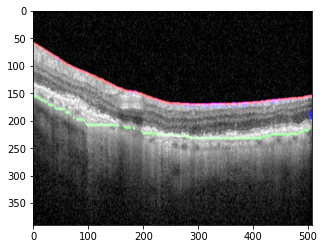

Length is  508 cropped_JB021.bmp
RPE VALS  [80, 80, 136, 135, 136, 137, 136, 137, 138, 136, 137, 138, 139, 140, 137, 138, 139, 140, 141, 137, 138, 139, 140, 141, 139, 140, 141, 142, 140, 141, 142, 141, 142, 143, 141, 142, 143, 141, 142, 143, 142, 143, 144, 142, 143, 144, 143, 144, 145, 146, 143, 144, 145, 146, 147, 142, 143, 144, 145, 142, 143, 148, 148, 150, 150, 154, 155, 154, 155, 156, 155, 156, 157, 155, 156, 157, 158, 156, 157, 158, 156, 157, 158, 156, 157, 158, 159, 157, 158, 159, 160, 157, 158, 159, 156, 157, 155, 156, 157, 155, 156, 157, 161, 162, 161, 162, 162, 163, 164, 162, 163, 164, 162, 163, 164, 165, 162, 163, 164, 165, 162, 163, 165, 165, 166, 165, 166, 166, 167, 168, 169, 166, 167, 168, 169, 165, 166, 167, 168, 169, 165, 166, 167, 168, 169, 166, 167, 168, 169, 168, 169, 170, 169, 170, 171, 170, 171, 171, 172, 173, 172, 173, 174, 172, 173, 174, 175, 173, 174, 175, 174, 175, 176, 174, 175, 176, 177, 175, 176, 177, 176, 177, 176, 177, 178, 179, 175, 176, 177, 178, 179, 175

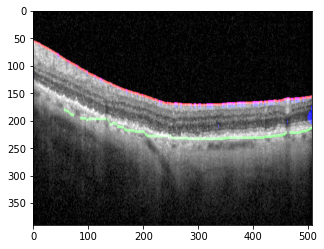

Length is  507 cropped_JB019.bmp
RPE VALS  [137, 136, 137, 138, 136, 137, 138, 139, 140, 137, 138, 139, 140, 137, 138, 139, 140, 80, 137, 138, 139, 140, 141, 79, 80, 81, 137, 138, 139, 140, 141, 142, 80, 137, 138, 139, 140, 141, 138, 139, 140, 138, 139, 140, 141, 141, 141, 142, 145, 146, 146, 145, 146, 144, 145, 143, 144, 145, 144, 145, 144, 145, 146, 144, 145, 146, 147, 144, 145, 146, 147, 148, 145, 146, 147, 148, 149, 145, 146, 147, 148, 149, 145, 146, 147, 148, 149, 146, 147, 148, 149, 157, 142, 143, 144, 145, 146, 147, 148, 149, 150, 157, 142, 143, 144, 145, 146, 147, 148, 149, 150, 142, 143, 144, 145, 146, 147, 148, 149, 150, 143, 144, 145, 146, 147, 148, 149, 150, 145, 146, 147, 148, 149, 150, 151, 148, 149, 150, 151, 152, 154, 149, 150, 151, 152, 153, 149, 150, 151, 152, 161, 162, 149, 150, 151, 152, 162, 149, 150, 151, 152, 153, 149, 150, 151, 152, 153, 154, 149, 150, 151, 152, 153, 154, 155, 150, 151, 152, 153, 154, 155, 150, 151, 152, 153, 154, 155, 156, 151, 152, 153, 154, 1

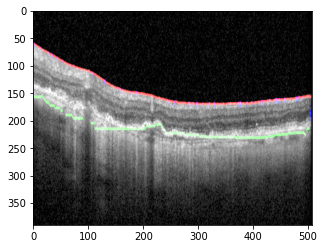

Length is  508 cropped_JB022.bmp
RPE VALS  [64, 65, 64, 65, 66, 64, 65, 64, 63, 64, 61, 62, 63, 64, 65, 61, 62, 63, 64, 65, 66, 64, 65, 66, 67, 68, 64, 65, 66, 67, 68, 69, 64, 65, 66, 67, 68, 69, 63, 64, 65, 66, 67, 68, 65, 66, 67, 68, 66, 67, 68, 67, 71, 74, 75, 76, 93, 94, 95, 74, 75, 76, 77, 78, 93, 94, 95, 142, 75, 76, 77, 78, 142, 143, 71, 72, 73, 77, 78, 79, 80, 142, 143, 144, 72, 80, 142, 143, 144, 145, 80, 81, 82, 83, 143, 144, 145, 146, 81, 82, 83, 143, 144, 145, 146, 144, 145, 146, 145, 146, 73, 73, 143, 144, 143, 144, 145, 144, 145, 146, 147, 148, 149, 150, 146, 147, 148, 149, 150, 147, 148, 149, 150, 147, 148, 149, 150, 108, 109, 148, 149, 150, 151, 107, 108, 109, 110, 149, 150, 151, 152, 107, 108, 109, 150, 151, 152, 107, 108, 109, 110, 150, 151, 152, 85, 150, 151, 152, 153, 105, 110, 111, 112, 151, 152, 153, 154, 109, 110, 151, 152, 153, 154, 110, 153, 97, 98, 96, 97, 98, 99, 97, 98, 99, 100, 101, 98, 99, 100, 101, 102, 99, 100, 101, 102, 103, 99, 100, 101, 102, 103, 104,

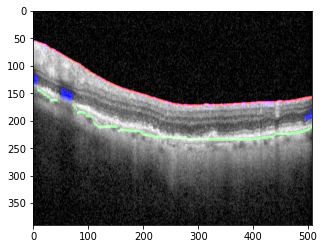

Length is  498 cropped_PL000.bmp
RPE VALS  [200, 201, 199, 200, 201, 202, 145, 146, 200, 201, 202, 203, 144, 145, 146, 201, 202, 145, 146, 201, 202, 203, 201, 202, 203, 203, 204, 204, 205, 204, 205, 204, 205, 206, 205, 148, 148, 149, 207, 148, 149, 150, 206, 207, 208, 149, 206, 207, 208, 206, 207, 208, 209, 206, 207, 208, 209, 206, 207, 208, 209, 206, 207, 208, 209, 206, 207, 208, 209, 142, 143, 144, 150, 207, 208, 141, 142, 143, 144, 149, 150, 150, 209, 210, 208, 209, 210, 211, 209, 210, 210, 211, 209, 210, 211, 212, 209, 210, 211, 212, 210, 211, 211, 210, 211, 212, 210, 211, 212, 213, 211, 212, 213, 212, 213, 140, 141, 142, 140, 141, 142, 140, 141, 139, 140, 141, 146, 138, 139, 140, 145, 146, 147, 139, 146, 147, 148, 214, 215, 212, 213, 214, 215, 211, 212, 213, 214, 215, 212, 213, 214, 161, 162, 163, 164, 161, 162, 163, 164, 161, 162, 163, 151, 152, 153, 213, 143, 144, 148, 149, 150, 151, 152, 153, 154, 212, 213, 142, 143, 144, 145, 148, 149, 150, 151, 152, 153, 213, 143, 144, 145, 1

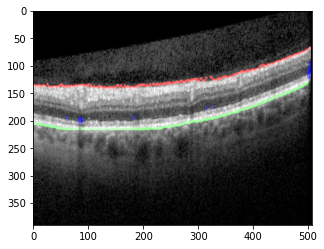

Length is  497 cropped_PL001.bmp
RPE VALS  [199, 200, 199, 200, 198, 199, 200, 198, 199, 200, 199, 200, 144, 199, 200, 201, 200, 201, 143, 143, 203, 204, 202, 203, 204, 203, 204, 205, 203, 204, 205, 206, 204, 205, 205, 205, 204, 205, 204, 205, 206, 204, 205, 206, 205, 206, 206, 206, 207, 206, 207, 208, 207, 207, 206, 207, 208, 207, 146, 147, 144, 145, 146, 147, 148, 144, 145, 146, 147, 148, 149, 146, 147, 148, 149, 147, 148, 210, 211, 209, 210, 211, 212, 210, 211, 212, 213, 211, 212, 213, 211, 212, 213, 211, 212, 213, 211, 212, 213, 214, 212, 213, 211, 212, 151, 152, 153, 154, 211, 212, 213, 151, 152, 153, 154, 211, 212, 147, 148, 212, 213, 212, 213, 212, 213, 214, 212, 213, 212, 213, 145, 146, 212, 213, 145, 146, 212, 213, 146, 213, 153, 153, 154, 155, 153, 154, 155, 156, 153, 154, 155, 156, 154, 155, 212, 213, 212, 213, 211, 212, 213, 211, 212, 213, 211, 212, 213, 211, 212, 213, 211, 212, 213, 211, 212, 143, 144, 211, 212, 211, 212, 213, 211, 212, 213, 214, 143, 144, 211, 212, 213, 1

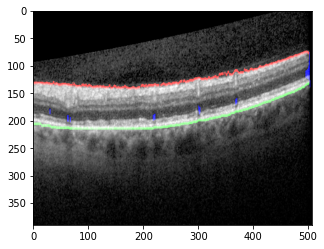

Length is  507 cropped_JB024.bmp
RPE VALS  [137, 138, 137, 138, 139, 138, 139, 138, 139, 140, 138, 139, 140, 141, 138, 139, 140, 141, 142, 138, 139, 140, 141, 142, 143, 138, 139, 140, 141, 142, 143, 138, 139, 140, 141, 142, 143, 139, 140, 141, 142, 140, 141, 142, 143, 141, 142, 143, 144, 141, 142, 143, 144, 145, 90, 91, 92, 141, 142, 143, 144, 145, 89, 90, 91, 92, 93, 142, 143, 144, 145, 146, 89, 90, 91, 92, 93, 94, 95, 96, 143, 144, 145, 146, 89, 90, 91, 92, 93, 94, 95, 96, 144, 145, 146, 90, 91, 92, 93, 94, 144, 145, 146, 147, 145, 146, 147, 145, 146, 147, 145, 146, 147, 148, 157, 146, 147, 156, 157, 157, 91, 92, 148, 149, 148, 149, 150, 148, 149, 150, 98, 99, 148, 149, 150, 151, 97, 98, 99, 100, 101, 145, 149, 150, 151, 97, 98, 99, 100, 101, 102, 145, 149, 150, 151, 152, 98, 99, 100, 101, 102, 150, 151, 152, 150, 151, 152, 96, 97, 151, 152, 153, 96, 97, 151, 152, 153, 154, 85, 151, 152, 153, 154, 84, 85, 86, 152, 153, 154, 84, 85, 86, 152, 153, 154, 84, 85, 86, 87, 92, 93, 102, 153,

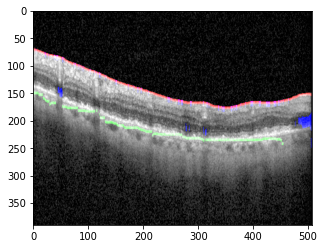

Length is  508 cropped_JB023.bmp
RPE VALS  [138, 139, 140, 141, 78, 79, 91, 92, 138, 139, 140, 141, 142, 77, 78, 79, 80, 89, 90, 91, 92, 93, 138, 139, 140, 141, 142, 143, 77, 78, 79, 80, 81, 87, 88, 89, 90, 91, 92, 137, 138, 139, 140, 141, 142, 143, 144, 77, 78, 79, 80, 81, 82, 86, 87, 88, 89, 90, 91, 92, 137, 138, 139, 140, 141, 142, 143, 144, 87, 88, 89, 90, 91, 92, 138, 139, 140, 141, 142, 143, 144, 87, 88, 89, 90, 91, 92, 137, 138, 139, 140, 141, 142, 143, 81, 82, 87, 88, 89, 136, 137, 138, 139, 140, 141, 142, 143, 144, 81, 82, 83, 84, 86, 87, 88, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 81, 82, 83, 86, 87, 136, 137, 138, 139, 140, 141, 142, 143, 137, 138, 141, 142, 143, 141, 142, 143, 144, 141, 142, 143, 144, 145, 146, 142, 143, 144, 145, 146, 147, 89, 90, 91, 143, 144, 145, 146, 147, 75, 76, 144, 145, 146, 147, 148, 144, 145, 146, 147, 148, 145, 146, 147, 148, 149, 85, 86, 87, 146, 147, 148, 149, 85, 86, 87, 104, 105, 146, 147, 148, 149, 86, 91, 92, 93, 147, 148, 88, 89,

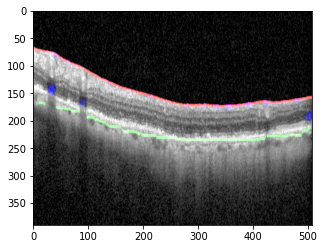

Length is  499 cropped_PL005.bmp
RPE VALS  [142, 143, 146, 147, 148, 149, 141, 142, 143, 146, 147, 148, 149, 199, 200, 201, 202, 141, 142, 143, 146, 147, 148, 149, 199, 200, 201, 202, 203, 146, 147, 148, 200, 201, 202, 203, 146, 147, 148, 200, 201, 202, 203, 131, 132, 199, 200, 201, 202, 203, 131, 132, 133, 134, 199, 200, 201, 202, 132, 133, 134, 145, 146, 145, 146, 202, 203, 201, 202, 203, 201, 202, 203, 201, 202, 203, 202, 202, 203, 204, 141, 142, 143, 144, 145, 146, 203, 140, 141, 142, 143, 144, 145, 146, 147, 143, 144, 145, 146, 147, 144, 145, 146, 147, 144, 145, 146, 147, 132, 144, 145, 146, 147, 131, 132, 133, 141, 142, 145, 146, 147, 130, 131, 132, 145, 146, 147, 205, 129, 130, 131, 144, 145, 146, 147, 148, 204, 205, 206, 129, 130, 131, 142, 143, 144, 145, 146, 147, 204, 205, 129, 130, 131, 141, 142, 143, 144, 145, 146, 204, 205, 130, 141, 142, 143, 144, 205, 141, 142, 143, 144, 145, 204, 205, 206, 137, 138, 139, 141, 142, 143, 144, 145, 146, 204, 205, 206, 136, 137, 138, 139, 1

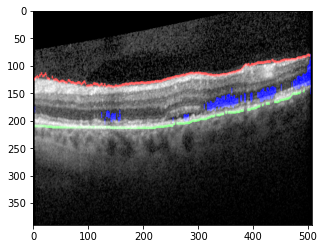

Length is  491 cropped_PL003.bmp
RPE VALS  [198, 199, 200, 201, 126, 198, 199, 200, 201, 126, 198, 199, 200, 200, 201, 200, 201, 126, 127, 126, 127, 132, 133, 134, 131, 132, 133, 127, 131, 132, 126, 127, 127, 128, 134, 133, 134, 135, 132, 133, 134, 135, 136, 132, 133, 134, 135, 123, 124, 125, 126, 133, 134, 123, 124, 125, 126, 132, 133, 134, 135, 141, 204, 205, 206, 132, 133, 134, 135, 136, 140, 141, 142, 149, 204, 205, 206, 134, 135, 136, 137, 141, 142, 143, 148, 149, 150, 203, 204, 205, 206, 143, 149, 203, 204, 205, 204, 205, 204, 205, 204, 205, 206, 204, 205, 206, 207, 153, 154, 204, 205, 206, 207, 131, 132, 152, 153, 154, 155, 156, 157, 204, 205, 206, 207, 131, 132, 153, 154, 155, 156, 157, 204, 205, 206, 207, 204, 205, 206, 207, 147, 205, 206, 207, 147, 205, 206, 207, 205, 206, 207, 205, 206, 207, 142, 206, 207, 208, 141, 142, 143, 144, 145, 146, 147, 148, 149, 152, 153, 206, 207, 208, 132, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 206, 207, 208, 132, 1

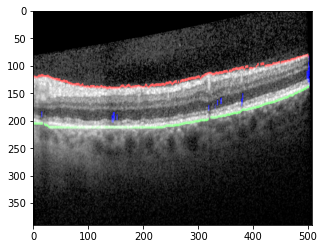

Length is  474 cropped_PL002.bmp
RPE VALS  [200, 201, 201, 200, 200, 201, 200, 201, 201, 202, 150, 150, 203, 203, 203, 141, 141, 140, 139, 140, 141, 207, 206, 207, 208, 206, 207, 206, 207, 206, 207, 208, 206, 207, 208, 207, 208, 207, 208, 156, 157, 206, 207, 208, 155, 156, 157, 158, 207, 154, 155, 156, 157, 155, 156, 208, 209, 210, 207, 208, 209, 210, 211, 208, 209, 210, 211, 208, 209, 210, 211, 209, 210, 211, 209, 210, 211, 141, 142, 210, 211, 210, 209, 210, 211, 210, 154, 155, 154, 155, 211, 212, 211, 212, 210, 211, 212, 210, 211, 212, 210, 211, 212, 211, 212, 210, 211, 149, 211, 212, 148, 149, 150, 210, 211, 212, 148, 149, 150, 211, 212, 211, 212, 213, 212, 155, 154, 155, 152, 153, 154, 155, 151, 152, 153, 154, 155, 211, 212, 213, 152, 153, 154, 155, 156, 210, 211, 212, 213, 214, 154, 155, 156, 157, 210, 211, 212, 213, 214, 156, 211, 212, 213, 211, 212, 213, 211, 212, 213, 211, 212, 213, 211, 212, 213, 211, 212, 213, 211, 212, 213, 211, 212, 213, 145, 146, 146, 150, 151, 150, 151, 1

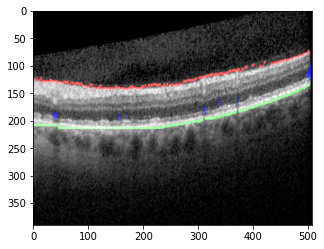

Length is  501 cropped_PL004.bmp
RPE VALS  [124, 125, 126, 198, 199, 124, 125, 198, 199, 123, 124, 125, 140, 141, 142, 143, 198, 199, 137, 139, 140, 141, 142, 143, 144, 199, 137, 140, 141, 142, 143, 199, 200, 199, 200, 198, 199, 200, 198, 199, 200, 198, 199, 200, 201, 122, 199, 200, 201, 202, 121, 122, 123, 199, 200, 201, 202, 121, 122, 123, 199, 200, 201, 202, 121, 122, 123, 124, 199, 200, 201, 202, 121, 122, 123, 124, 125, 129, 130, 131, 132, 133, 199, 200, 201, 202, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 200, 201, 202, 122, 123, 124, 125, 126, 127, 128, 129, 130, 200, 201, 202, 123, 124, 125, 126, 127, 128, 129, 201, 124, 125, 124, 125, 125, 126, 125, 126, 131, 132, 130, 131, 132, 133, 130, 131, 132, 133, 201, 202, 203, 131, 200, 201, 202, 203, 204, 201, 202, 203, 204, 201, 202, 203, 204, 137, 141, 202, 203, 204, 137, 141, 202, 203, 204, 132, 133, 137, 203, 131, 132, 133, 134, 131, 132, 133, 134, 132, 133, 144, 144, 145, 129, 129, 205, 204, 205, 206, 203, 204, 2

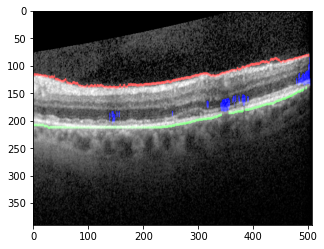

Length is  500 cropped_PL006.bmp
RPE VALS  [199, 200, 201, 199, 200, 201, 199, 200, 201, 199, 200, 201, 200, 144, 144, 145, 146, 145, 146, 200, 201, 200, 201, 202, 200, 201, 202, 200, 201, 202, 203, 201, 202, 203, 144, 202, 203, 204, 142, 143, 144, 202, 203, 204, 142, 143, 203, 204, 142, 203, 203, 203, 204, 134, 135, 204, 134, 135, 203, 204, 205, 141, 142, 202, 203, 204, 140, 141, 142, 143, 144, 203, 204, 142, 203, 204, 204, 205, 204, 142, 143, 144, 204, 205, 206, 141, 142, 143, 144, 204, 205, 206, 140, 141, 142, 143, 144, 204, 205, 206, 140, 141, 142, 143, 205, 139, 140, 141, 142, 137, 138, 139, 140, 141, 142, 143, 205, 206, 137, 138, 139, 140, 141, 142, 143, 136, 137, 138, 135, 136, 137, 135, 136, 136, 135, 136, 137, 135, 136, 136, 143, 136, 142, 143, 144, 145, 142, 143, 144, 145, 146, 147, 141, 142, 143, 144, 145, 146, 147, 207, 208, 209, 142, 207, 208, 209, 207, 208, 207, 208, 141, 208, 209, 140, 141, 141, 208, 209, 207, 208, 209, 207, 208, 209, 208, 209, 209, 145, 146, 147, 142, 1

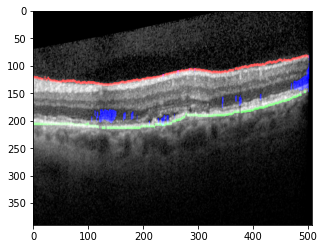

Length is  507 cropped_PL007.bmp
RPE VALS  [198, 199, 200, 198, 199, 200, 134, 197, 198, 199, 200, 133, 134, 135, 196, 197, 198, 199, 133, 134, 135, 197, 198, 199, 132, 133, 134, 135, 199, 200, 130, 131, 132, 133, 134, 135, 197, 198, 199, 200, 201, 130, 131, 132, 133, 134, 135, 196, 197, 198, 199, 200, 201, 130, 131, 132, 133, 134, 197, 198, 199, 200, 201, 129, 130, 131, 132, 137, 138, 198, 199, 200, 201, 129, 130, 131, 137, 138, 199, 200, 201, 199, 200, 199, 198, 199, 200, 199, 200, 201, 199, 200, 201, 199, 200, 201, 202, 200, 201, 134, 135, 136, 135, 136, 137, 138, 139, 140, 137, 138, 139, 140, 141, 138, 139, 140, 141, 201, 202, 137, 136, 137, 138, 136, 137, 138, 145, 144, 145, 146, 199, 200, 201, 133, 143, 144, 145, 199, 200, 201, 202, 203, 132, 133, 139, 140, 141, 142, 143, 144, 145, 200, 201, 202, 203, 204, 132, 133, 139, 140, 141, 142, 143, 144, 145, 201, 202, 203, 204, 132, 133, 139, 140, 141, 142, 143, 144, 145, 201, 202, 203, 204, 132, 133, 134, 139, 140, 141, 142, 143, 144, 2

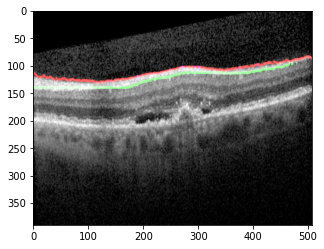

In [117]:
import os


MIN_ROW = 10
MAX_ROW = 400
RANGE_THRESHOLD = 145
min_thrshld, max_thrshld = 1, 50 ## TODO-1 MAKE THESE INTENSITIES DYNAMIC

os.chdir('/content/drive/My Drive/Colab Notebooks/AMD/Cropped_Data/')
image_files = os.listdir()
#os.chdir('/content/drive/My Drive/Colab Notebooks/AMD/Cropped_Data/')
#for img_name in image_files:
#img_name = image_files[25]
#img = img[MIN_ROW:MAX_ROW,500:,:]
#new_name = 'cropped_'+img_name
#cv.imwrite(new_name, img)

### THE PROBLEM IS WITH DETECTION OF ILM ---> FIX THAT --> OUTLIERS ARE BEING MARKED
for img_name in image_files:
  #img_name = image_files[25]
  #img_name = 'cropped_JB016.bmp'
  img = cv.imread(img_name)
  md_img = apply_median_filter(img)
  clus_img = apply_k_mean_clustering(md_img)
  ed_img = apply_canny_edge(clus_img)
  ilm_pos, ilm_dict = detect_ilm(ed_img)
  print("Length is ", len(ilm_dict), img_name)
  
  ## detecting RPE
  gray = cv.cvtColor(md_img, cv.COLOR_BGR2GRAY)
  vals = return_vals(ilm_dict)
  ilm_mode = stats.mode(vals)
  ilm_mode = ilm_mode[0][0]
  #print("ILM MODE VALS ",ilm_mode)
  (hi_rows, high_cols) = find_high_intensity_areas(gray)
  print("RPE VALS ",hi_rows)
  (hi_rows, high_cols) = remove_intensity_outliers(ilm_mode, ilm_dict, hi_rows, high_cols)
  print("RPE VALS ",hi_rows)
  #plt.imshow(gray)
  #plt.show()
  mode = stats.mode(hi_rows)
  rpe_row = mode[0][0]
  rpe_col = find_RPE_col(hi_rows, high_cols, rpe_row) 
  rpe_pos, rpe_dict = segment_rpe(gray, rpe_col, rpe_row, gray.shape[1])

  ## detecting Fluid
  #print(rpe_dict.keys())
  #print("Length of RPE Dict is ",len(rpe_dict))
  #print(rpe_pos)
  fluid_pos = seg_fluid(gray, ilm_pos, rpe_pos, min_thrshld, max_thrshld, ilm_dict, rpe_dict)

  #count, th = 1, 10
  segmented_scan_ilm_rpe_final = img.copy()

  for ilm_position in ilm_pos:
    (row, col) = ilm_position
    segmented_scan_ilm_rpe_final[row:row+5, col, 0] = 255

  for f in fluid_pos:
    (row_f, col_f) = f
    segmented_scan_ilm_rpe_final[row_f:row_f+10, col_f, 2] = 255

  for rpe_position in rpe_pos:
    (row_r, col_r) = rpe_position
    segmented_scan_ilm_rpe_final[row_r, col_r, 1] = 255
    segmented_scan_ilm_rpe_final[row_r+1, col_r, 1] = 255
    segmented_scan_ilm_rpe_final[row_r+2, col_r, 1] = 255
    segmented_scan_ilm_rpe_final[row_r+3, col_r, 1] = 255
    segmented_scan_ilm_rpe_final[row_r+4, col_r, 1] = 255

  fig = plt.figure(figsize=(5, 5))

  plt.imshow(segmented_scan_ilm_rpe_final)
  plt.show()

  #break


(390, 508, 3)


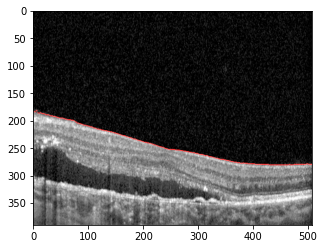

In [12]:
print(img.shape)
img_ilm = img.copy()
for position in ilm_pos:
  (row, col) = position
  img_ilm[row:row+2, col, 0] = 255

fig = plt.figure(figsize=(5, 5))
plt.imshow(img_ilm)
plt.show()

In [ ]:
print(filtered_img.shape)

(390, 508, 3)


## Detecting RPE (HRC)

In [ ]:
print(filtered_img.shape)

(390, 508, 3)


In [ ]:
print(filtered_img.shape)

(390, 508, 3)


In [ ]:
print("Helo")

Helo


In [14]:
from collections import Counter
my_dict = dict()
print(minVal, maxVal, minLoc, maxLoc)
print(gray.shape)

for col in range(cols):
  for row in range(rows):
    if gray[row, col] in my_dict:
      my_dict[gray[row, col]] += 1
    else:
      my_dict[gray[row, col]] = 1
      #print("In the loop", row, col)

print(my_dict)
#Counter(gray).keys()

0.0 255.0 (2, 0) (23, 236)
(390, 508)
{16: 2550, 6: 3911, 11: 3450, 3: 4751, 2: 5590, 15: 2675, 26: 1042, 19: 2086, 18: 2141, 5: 4322, 24: 1365, 17: 2367, 8: 3708, 27: 960, 13: 2893, 22: 1645, 4: 4713, 1: 5894, 0: 40550, 9: 3668, 14: 2809, 30: 617, 7: 3865, 10: 3482, 21: 1916, 31: 601, 23: 1672, 32: 449, 36: 259, 50: 288, 77: 318, 103: 394, 126: 590, 149: 762, 160: 551, 186: 202, 203: 168, 205: 125, 215: 95, 238: 31, 244: 31, 240: 37, 231: 35, 219: 85, 177: 323, 173: 381, 182: 245, 179: 261, 158: 661, 155: 675, 152: 659, 139: 708, 123: 551, 119: 596, 117: 633, 118: 539, 129: 715, 132: 651, 136: 728, 144: 735, 142: 682, 135: 733, 122: 670, 109: 438, 98: 414, 151: 653, 154: 761, 137: 724, 128: 662, 120: 599, 114: 526, 87: 378, 79: 323, 71: 386, 59: 382, 56: 344, 60: 359, 64: 415, 67: 397, 54: 356, 42: 177, 34: 372, 43: 226, 48: 241, 57: 348, 52: 329, 44: 230, 35: 273, 39: 286, 53: 347, 47: 185, 46: 265, 25: 1261, 37: 227, 104: 396, 145: 703, 170: 411, 202: 133, 204: 177, 217: 62, 185: 20

In [20]:
from scipy import stats
mode = stats.mode(hi_rows)
mean = np.mean(hi_rows)

print(mode[0], mean)

[342] 305.0514705882353


In [21]:
rpe_row = mode[0][0]
rpe_col = find_RPE_col(hi_rows, high_cols, rpe_row)
print("Row and Col = ", rpe_row, rpe_col)

Row and Col =  342 460


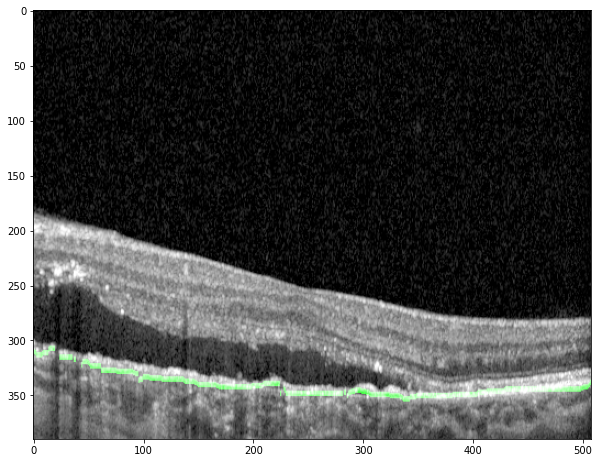

In [23]:
rpe_pos = segment_rpe(gray, rpe_col, rpe_row, gray.shape[1])
img_rpe = img.copy()
for position in rpe_pos:
  (row, col) = position
  img_rpe[row:row+5, col, 1] = 255

fig = plt.figure(figsize=(10, 10))
plt.imshow(img_rpe)
plt.show()

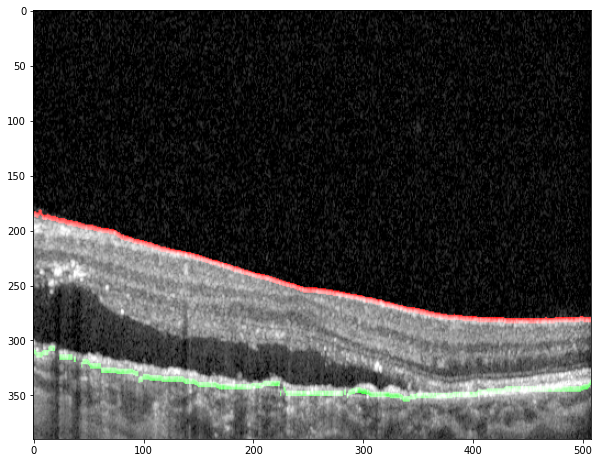

In [24]:
segmented_scan_ilm_rpe = img.copy()
for ilm_position in ilm_pos:
  (row, col) = ilm_position
  segmented_scan_ilm_rpe[row:row+5, col, 0] = 255

for rpe_position in rpe_pos:
  (row, col) = rpe_position
  segmented_scan_ilm_rpe[row:row+5, col, 1] = 255

fig = plt.figure(figsize=(10, 10))
plt.imshow(segmented_scan_ilm_rpe)
plt.show()

## Segmentation of Intra-Retinal Fluid

507
(390, 508)
Counter is high -1


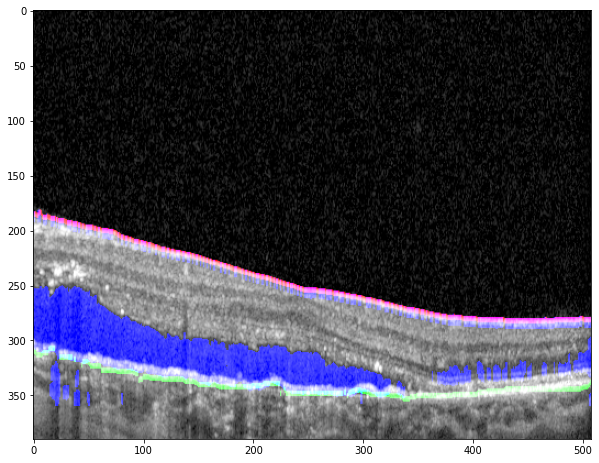

In [67]:
min_thrshld, max_thrshld = 0, 80 ## TODO-1 MAKE THESE INTENSITIES DYNAMIC
fluid_pos = seg_fluid(gray, ilm_pos, rpe_pos, min_thrshld, max_thrshld)

segmented_scan_ilm_rpe_final = img.copy()
for ilm_position in ilm_pos:
  (row, col) = ilm_position
  segmented_scan_ilm_rpe_final[row:row+5, col, 0] = 255

for rpe_position in rpe_pos:
  (row, col) = rpe_position
  segmented_scan_ilm_rpe_final[row:row+5, col, 1] = 255

for f in fluid_pos:
  (row, col) = f
  segmented_scan_ilm_rpe_final[row:row+10, col, 2] = 255



fig = plt.figure(figsize=(10, 10))
plt.imshow(segmented_scan_ilm_rpe_final)
plt.show()